# Goal
Analyze the export performance of semiconductor products (specifically integrated circuits) by destination country to identify high-value markets and trends using trade data.

# Data Loading

| Column                                                 | Description                                                                                         |
| ------------------------------------------------------ | --------------------------------------------------------------------------------------------------- |
| **typeCode**                                           | Type of dataset (e.g., trade data category, usually 'C' for commodity)                              |
| **freqCode**                                           | Frequency of the data (usually annual or monthly)                                                   |
| **refPeriodId**, **refYear**, **refMonth**, **period** | Time indicators — useful for time-series analysis                                                   |
| **reporterCode**, **reporterISO**, **reporterDesc**    | Country that is reporting the trade (e.g., Taiwan)                                                  |
| **flowCode**, **flowDesc**                             | Type of trade: Import or Export                                                                     |
| **partnerCode**, **partnerISO**, **partnerDesc**       | Trade partner (who you're buying from or selling to)                                                |
| **cmdCode**                                            | HS (Harmonized System) commodity code — identifies the product (e.g., 8542 for ICs)                 |
| **cmdDesc**                                            | Product description (e.g., “Electronic integrated circuits”)                                        |
| **qty**, **netWgt**, **grossWgt**                      | Quantity and weight of traded goods (may be True/False if not filled correctly)                     |
| **fobvalue**                                           | **Free On Board** value — cost of goods at point of export (good for export-focused value)          |
| **cifvalue**                                           | **Cost, Insurance, and Freight** — includes shipping/import costs (useful for import-side analysis) |
| **motCode**, **motDesc**                               | Mode of transport (e.g., sea, air)                                                                  |
| **customsCode**, **customsDesc**                       | Customs declaration info                                                                            |
| **qtyUnitCode**, **qtyUnitAbbr**                       | Units of measurement (e.g., kg, pieces)                                                             |
| **isReported**                                         | Whether the data is officially reported (vs. estimated)                                             |

In [82]:
import pandas as pd, calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import platform
from pathlib import Path
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.ensemble import RandomForestRegressor
pd.reset_option('display.max_rows')

In [ ]:
base_path = Path("D:/Git_folder/Dibimbing---DSDA/Final Project Data Science/data_monthly")


if platform.system() == "Windows":
    base_path = Path("D:/Git_folder/Dibimbing---DSDA/Final Project Data Science/data_monthly")
else:
    base_path = Path("/Users/hbb/Document/Dibimbing---DSDA/Final Project Data Science/data_monthly")

file_names = [
    "TradeDataJan25.csv", "TradeDataFeb25.csv", "TradeDataMar25.csv", "TradeDataApr25.csv",
    "TradeDataMay25.csv", "TradeDataJan24.csv", "TradeDataFeb24.csv",
    "TradeDataMar24.csv", "TradeDataApr24.csv", "TradeDataMay24.csv", "TradeDataJune24.csv",
    "TradeDataJuly24.csv", "TradeDataAug24.csv", "TradeDataSep24.csv", "TradeDataOct24.csv",
    "TradeDataNov24.csv", "TradeDataDec24.csv", "TradeDataJan23.csv", "TradeDataFeb23.csv",
    "TradeDataMar23.csv", "TradeDataApr23.csv", "TradeDataMay23.csv", "TradeDataJune23.csv",
    "TradeDataJuly23.csv", "TradeDataAug23.csv", "TradeDataSep23.csv", "TradeDataOct23.csv",
    "TradeDataNov23.csv", "TradeDataDec23.csv", "TradeDataJan22.csv", "TradeDataFeb22.csv",
    "TradeDataMar22.csv", "TradeDataApr22.csv", "TradeDataMay22.csv", "TradeDataJune22.csv",
    "TradeDataJuly22.csv", "TradeDataAug22.csv", "TradeDataSep22.csv", "TradeDataOct22.csv",
    "TradeDataNov22.csv", "TradeDataDec22.csv", "TradeDataJan21.csv", "TradeDataFeb21.csv",
    "TradeDataMar21.csv", "TradeDataApr21.csv", "TradeDataMay21.csv", "TradeDataJune21.csv",
    "TradeDataJuly21.csv", "TradeDataAug21.csv", "TradeDataSep21.csv", "TradeDataOct21.csv",
    "TradeDataNov21.csv", "TradeDataDec21.csv", "TradeDataJan20.csv", "TradeDataFeb20.csv",
    "TradeDataMar20.csv", "TradeDataApr20.csv", "TradeDataMay20.csv", "TradeDataJune20.csv",
    "TradeDataJuly20.csv", "TradeDataAug20.csv", "TradeDataSep20.csv", "TradeDataOct20.csv",
    "TradeDataNov20.csv", "TradeDataDec20.csv"
]

files = [str(base_path / name) for name in file_names]


schema = pd.read_csv(files[0], dtype=str, encoding="latin1", low_memory=False).columns.tolist()

def read_and_fix(fp):
    df = pd.read_csv(fp, dtype=str, encoding="latin1", low_memory=False)
    df = df.reindex(columns=schema)


    mask = df["freqCode"].str.fullmatch(r"\d{8}", na=False)
    if mask.any():
        cols = df.columns.tolist()
        j = cols.index("freqCode")

        bad = df.loc[mask, cols].copy()
        bad.iloc[:, j+1:] = bad.iloc[:, j:-1].values
        bad.iloc[:, j] = "M"

        rpid = bad["refPeriodId"].str.extract(r"(\d{8})", expand=False)
        ok = rpid.notna()
        bad.loc[ok, "refYear"]  = rpid[ok].str.slice(0, 4)
        bad.loc[ok, "refMonth"] = rpid[ok].str.slice(4, 6).astype(int).astype(str)
        bad.loc[ok, "period"]   = (bad.loc[ok, "refYear"].astype(int)*100 + bad.loc[ok, "refMonth"].astype(int)).astype(str)

        df.loc[mask, cols] = bad.values

    return df

dfs = [read_and_fix(f) for f in files]
merged = pd.concat(dfs, ignore_index=True)

print(merged.iloc[0][["typeCode","freqCode","refPeriodId","refYear","refMonth","period"]])

#merged.to_csv("merged_fixed.csv", index=False, encoding="utf-8")

typeCode              M
freqCode              M
refPeriodId    20250101
refYear            2025
refMonth              1
period           202501
Name: 0, dtype: object


In [ ]:
merged

typeCode freqCode refPeriodId refYear refMonth  period reporterCode  \
0              M        M    20250101    2025        1  202501           36   
1              M        M    20250101    2025        1  202501           36   
2              M        M    20250101    2025        1  202501           36   
3              M        M    20250101    2025        1  202501           36   
4              M        M    20250101    2025        1  202501           36   
...          ...      ...         ...     ...      ...     ...          ...   
6499995        M        M    20201201    2020       12  202012          764   
6499996        M        M    20201201    2020       12  202012          764   
6499997        M        M    20201201    2020       12  202012          764   
6499998        M        M    20201201    2020       12  202012          764   
6499999        M        M    20201201    2020       12  202012          764   

        reporterISO reporterDesc flowCode  ... netWgt isNetWgtEstimated  \
0               AUS    Australia        X  ...    NaN             false   
1               AUS    Australia        X  ...    NaN             false   
2               AUS    Australia        X  ...    NaN             false   
3               AUS    Australia        X  ...    NaN             false   
4               AUS    Australia        X  ...    NaN             false   
...             ...          ...      ...  ...    ...               ...   
6499995         THA     Thailand        X  ...      0             false   
6499996         THA     Thailand        X  ...      0             false   
6499997         THA     Thailand        X  ...      0             false   
6499998         THA     Thailand        X  ...      0             false   
6499999         THA     Thailand        X  ...      0             false   

        grossWgt isGrossWgtEstimated cifvalue         fobvalue  \
0              0               false      NaN         1289.771   
1              0               false      NaN         2085.918   
2              0               false      NaN  25975646838.107   
3              0               false      NaN           379.71   
4          9.133               false      NaN      7397398.731   
...          ...                 ...      ...              ...   
6499995        0               false      NaN            0.033   
6499996        0               false      NaN     25769533.042   
6499997        0               false      NaN         9358.809   
6499998        0               false      NaN       181567.864   
6499999        0               false      NaN        73221.782   

            primaryValue legacyEstimationFlag isReported isAggregate  
0               1289.771                    0      false        true  
1               2085.918                    0      false        true  
2        25975646838.107                    0      false        true  
3                 379.71                    0      false        true  
4            7397398.731                    0      false        true  
...                  ...                  ...        ...         ...  
6499995            0.033                    0      false        true  
6499996     25769533.042                    0      false        true  
6499997         9358.809                    0      false        true  
6499998       181567.864                    0      false        true  
6499999        73221.782                    0      false        true  

[6500000 rows x 47 columns]

In [ ]:
df = merged
df

typeCode freqCode refPeriodId refYear refMonth  period reporterCode  \
0              M        M    20250101    2025        1  202501           36   
1              M        M    20250101    2025        1  202501           36   
2              M        M    20250101    2025        1  202501           36   
3              M        M    20250101    2025        1  202501           36   
4              M        M    20250101    2025        1  202501           36   
...          ...      ...         ...     ...      ...     ...          ...   
6499995        M        M    20201201    2020       12  202012          764   
6499996        M        M    20201201    2020       12  202012          764   
6499997        M        M    20201201    2020       12  202012          764   
6499998        M        M    20201201    2020       12  202012          764   
6499999        M        M    20201201    2020       12  202012          764   

        reporterISO reporterDesc flowCode  ... netWgt isNetWgtEstimated  \
0               AUS    Australia        X  ...    NaN             false   
1               AUS    Australia        X  ...    NaN             false   
2               AUS    Australia        X  ...    NaN             false   
3               AUS    Australia        X  ...    NaN             false   
4               AUS    Australia        X  ...    NaN             false   
...             ...          ...      ...  ...    ...               ...   
6499995         THA     Thailand        X  ...      0             false   
6499996         THA     Thailand        X  ...      0             false   
6499997         THA     Thailand        X  ...      0             false   
6499998         THA     Thailand        X  ...      0             false   
6499999         THA     Thailand        X  ...      0             false   

        grossWgt isGrossWgtEstimated cifvalue         fobvalue  \
0              0               false      NaN         1289.771   
1              0               false      NaN         2085.918   
2              0               false      NaN  25975646838.107   
3              0               false      NaN           379.71   
4          9.133               false      NaN      7397398.731   
...          ...                 ...      ...              ...   
6499995        0               false      NaN            0.033   
6499996        0               false      NaN     25769533.042   
6499997        0               false      NaN         9358.809   
6499998        0               false      NaN       181567.864   
6499999        0               false      NaN        73221.782   

            primaryValue legacyEstimationFlag isReported isAggregate  
0               1289.771                    0      false        true  
1               2085.918                    0      false        true  
2        25975646838.107                    0      false        true  
3                 379.71                    0      false        true  
4            7397398.731                    0      false        true  
...                  ...                  ...        ...         ...  
6499995            0.033                    0      false        true  
6499996     25769533.042                    0      false        true  
6499997         9358.809                    0      false        true  
6499998       181567.864                    0      false        true  
6499999        73221.782                    0      false        true  

[6500000 rows x 47 columns]

# Data Understanding

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500000 entries, 0 to 6499999
Data columns (total 47 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   typeCode                  object
 1   freqCode                  object
 2   refPeriodId               object
 3   refYear                   object
 4   refMonth                  object
 5   period                    object
 6   reporterCode              object
 7   reporterISO               object
 8   reporterDesc              object
 9   flowCode                  object
 10  flowDesc                  object
 11  partnerCode               object
 12  partnerISO                object
 13  partnerDesc               object
 14  partner2Code              object
 15  partner2ISO               object
 16  partner2Desc              object
 17  classificationCode        object
 18  classificationSearchCode  object
 19  isOriginalClassification  object
 20  cmdCode                   object
 21  cmdDesc 

We have 47 tables, but not all of them is useful

In [ ]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

typeCode: 1 unique values
freqCode: 1 unique values
refPeriodId: 65 unique values
refYear: 6 unique values
refMonth: 12 unique values
period: 65 unique values
reporterCode: 128 unique values
reporterISO: 128 unique values
reporterDesc: 128 unique values
flowCode: 2 unique values
flowDesc: 2 unique values
partnerCode: 247 unique values
partnerISO: 245 unique values
partnerDesc: 247 unique values
partner2Code: 243 unique values
partner2ISO: 243 unique values
partner2Desc: 243 unique values
classificationCode: 4 unique values
classificationSearchCode: 1 unique values
isOriginalClassification: 1 unique values
cmdCode: 2 unique values
cmdDesc: 2 unique values
aggrLevel: 2 unique values
isLeaf: 1 unique values
customsCode: 1 unique values
customsDesc: 1 unique values
mosCode: 1 unique values
motCode: 1 unique values
motDesc: 1 unique values
qtyUnitCode: 3 unique values
qtyUnitAbbr: 2 unique values
qty: 100350 unique values
isQtyEstimated: 2 unique values
altQtyUnitCode: 4 unique values
altQt

In [ ]:
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print(df[col].nunique())
    print("-" * 40)

Column: typeCode
['M']
1
----------------------------------------
Column: freqCode
['M']
1
----------------------------------------
Column: refPeriodId
['20250101' '20250201' '20250301' '20250401' '20250501' '20240101'
 '20240201' '20240301' '20240401' '20240501' '20240601' '20240701'
 '20240801' '20240901' '20241001' '20241101' '20241201' '20230101'
 '20230201' '20230301' '20230401' '20230501' '20230601' '20230701'
 '20230801' '20230901' '20231001' '20231101' '20231201' '20220101'
 '20220201' '20220301' '20220401' '20220501' '20220601' '20220701'
 '20220801' '20220901' '20221001' '20221101' '20221201' '20210101'
 '20210201' '20210301' '20210401' '20210501' '20210601' '20210701'
 '20210801' '20210901' '20211001' '20211101' '20211201' '20200101'
 '20200201' '20200301' '20200401' '20200501' '20200601' '20200701'
 '20200801' '20200901' '20201001' '20201101' '20201201']
65
----------------------------------------
Column: refYear
['2025' '2024' '2023' '2022' '2021' '2020']
6
---------------

(reportercode, reporterdesc, partnercode, partnerdesc, refYear, refMonth, flowcode, flowdesc, cmdCode, cmdDesc, fobvalue, cifvalue, netWgt, grossWgt) Apparently these are the tables that is necessary for this analysis. First, need to copy the original data.

In [ ]:
df = df[(df["reporterDesc"] != "World") & (df["partnerDesc"] != "World")]
# (optional) assert no aggregates remain
assert not ((df["reporterDesc"]=="World") | (df["partnerDesc"]=="World")).any()


In [ ]:
df_copy = df.copy()

In [ ]:
df_copy

typeCode freqCode refPeriodId refYear refMonth  period reporterCode  \
0              M        M    20250101    2025        1  202501           36   
1              M        M    20250101    2025        1  202501           36   
3              M        M    20250101    2025        1  202501           36   
5              M        M    20250101    2025        1  202501           36   
6              M        M    20250101    2025        1  202501           36   
...          ...      ...         ...     ...      ...     ...          ...   
6499995        M        M    20201201    2020       12  202012          764   
6499996        M        M    20201201    2020       12  202012          764   
6499997        M        M    20201201    2020       12  202012          764   
6499998        M        M    20201201    2020       12  202012          764   
6499999        M        M    20201201    2020       12  202012          764   

        reporterISO reporterDesc flowCode  ... netWgt isNetWgtEstimated  \
0               AUS    Australia        X  ...    NaN             false   
1               AUS    Australia        X  ...    NaN             false   
3               AUS    Australia        X  ...    NaN             false   
5               AUS    Australia        X  ...    NaN             false   
6               AUS    Australia        X  ...    NaN             false   
...             ...          ...      ...  ...    ...               ...   
6499995         THA     Thailand        X  ...      0             false   
6499996         THA     Thailand        X  ...      0             false   
6499997         THA     Thailand        X  ...      0             false   
6499998         THA     Thailand        X  ...      0             false   
6499999         THA     Thailand        X  ...      0             false   

        grossWgt isGrossWgtEstimated cifvalue      fobvalue  primaryValue  \
0              0               false      NaN      1289.771      1289.771   
1              0               false      NaN      2085.918      2085.918   
3              0               false      NaN        379.71        379.71   
5          0.294               false      NaN       46541.3       46541.3   
6          0.041               false      NaN       370.373       370.373   
...          ...                 ...      ...           ...           ...   
6499995        0               false      NaN         0.033         0.033   
6499996        0               false      NaN  25769533.042  25769533.042   
6499997        0               false      NaN      9358.809      9358.809   
6499998        0               false      NaN    181567.864    181567.864   
6499999        0               false      NaN     73221.782     73221.782   

        legacyEstimationFlag isReported isAggregate  
0                          0      false        true  
1                          0      false        true  
3                          0      false        true  
5                          0      false        true  
6                          0      false        true  
...                      ...        ...         ...  
6499995                    0      false        true  
6499996                    0      false        true  
6499997                    0      false        true  
6499998                    0      false        true  
6499999                    0      false        true  

[6108662 rows x 47 columns]

In [ ]:
# Keep only the necessary columns for analysis
columns_to_keep = [
    'reporterCode', 'reporterDesc', 'partnerCode', 'partnerDesc',
    'period', 'flowCode', 'flowDesc',
    'cmdCode', 'cmdDesc', 'qty', 'fobvalue', 'cifvalue', 'netWgt', 'grossWgt', 'primaryValue'
]
df_copy = df_copy[columns_to_keep]
df_copy.head()

reporterCode reporterDesc partnerCode               partnerDesc  period  \
0           36    Australia         238  Falkland Isds (Malvinas)  202501   
1           36    Australia          84                    Belize  202501   
3           36    Australia         140      Central African Rep.  202501   
5           36    Australia          90              Solomon Isds  202501   
6           36    Australia         724                     Spain  202501   

  flowCode flowDesc cmdCode                         cmdDesc qty  fobvalue  \
0        X   Export   TOTAL                 All Commodities   0  1289.771   
1        X   Export   TOTAL                 All Commodities   0  2085.918   
3        X   Export   TOTAL                 All Commodities   0    379.71   
5        X   Export    8542  Electronic integrated circuits   0   46541.3   
6        X   Export    8542  Electronic integrated circuits   0   370.373   

  cifvalue netWgt grossWgt primaryValue  
0      NaN    NaN        0     1289.771  
1      NaN    NaN        0     2085.918  
3      NaN    NaN        0       379.71  
5      NaN    NaN    0.294      46541.3  
6      NaN    NaN    0.041      370.373

In [ ]:
# Split export data
df_copy_export = df_copy[df_copy['flowDesc'] == 'Export']

# Split import data
df_copy_import = df_copy[df_copy['flowDesc'] == 'Import']


In [ ]:
df_copy_export.head()

reporterCode reporterDesc partnerCode               partnerDesc  period  \
0           36    Australia         238  Falkland Isds (Malvinas)  202501   
1           36    Australia          84                    Belize  202501   
3           36    Australia         140      Central African Rep.  202501   
5           36    Australia          90              Solomon Isds  202501   
6           36    Australia         724                     Spain  202501   

  flowCode flowDesc cmdCode                         cmdDesc qty  fobvalue  \
0        X   Export   TOTAL                 All Commodities   0  1289.771   
1        X   Export   TOTAL                 All Commodities   0  2085.918   
3        X   Export   TOTAL                 All Commodities   0    379.71   
5        X   Export    8542  Electronic integrated circuits   0   46541.3   
6        X   Export    8542  Electronic integrated circuits   0   370.373   

  cifvalue netWgt grossWgt primaryValue  
0      NaN    NaN        0     1289.771  
1      NaN    NaN        0     2085.918  
3      NaN    NaN        0       379.71  
5      NaN    NaN    0.294      46541.3  
6      NaN    NaN    0.041      370.373

In [ ]:
df_copy_import.head()

reporterCode reporterDesc partnerCode   partnerDesc  period flowCode  \
231           36    Australia         703      Slovakia  202501        M   
232           36    Australia          56       Belgium  202501        M   
233           36    Australia         504       Morocco  202501        M   
234           36    Australia         372       Ireland  202501        M   
235           36    Australia         710  South Africa  202501        M   

    flowDesc cmdCode                         cmdDesc    qty  fobvalue  \
231   Import    8542  Electronic integrated circuits   5389  9306.847   
232   Import    8542  Electronic integrated circuits      4   666.323   
233   Import    8542  Electronic integrated circuits  25025  8280.091   
234   Import    8542  Electronic integrated circuits     20  1637.654   
235   Import    8542  Electronic integrated circuits     60  1993.038   

     cifvalue netWgt grossWgt primaryValue  
231  9385.708  5.744    0.004     9385.708  
232   725.776   0.39    0.001      725.776  
233   8568.74  5.062        0      8568.74  
234  1736.472  0.934        0     1736.472  
235  2012.715  1.232        0     2012.715

# Data Cleaning (Handling Missing Values)

## Export

In [ ]:
df_copy_export.describe()

reporterCode reporterDesc partnerCode partnerDesc   period flowCode  \
count       1491617      1491617     1491617     1491617  1491617  1491617   
unique          128          128         245         245       65        1   
top             642      Romania         276     Germany   202410        X   
freq         119045       119045       27372       27372    25701  1491617   

       flowDesc  cmdCode          cmdDesc      qty fobvalue cifvalue   netWgt  \
count   1491617  1491617          1491617  1491617  1491617   320488  1461022   
unique        1        2                2    27946  1204986     7529    69349   
top      Export    TOTAL  All Commodities        0     1000        0        0   
freq    1491617  1260233          1260233  1431972      528   312774  1263255   

       grossWgt primaryValue  
count   1491617      1491617  
unique     5531      1204985  
top           0         1000  
freq    1483973          528

In [ ]:
df_copy_export.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1491617 entries, 0 to 6499999
Data columns (total 15 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   reporterCode  1491617 non-null  object
 1   reporterDesc  1491617 non-null  object
 2   partnerCode   1491617 non-null  object
 3   partnerDesc   1491617 non-null  object
 4   period        1491617 non-null  object
 5   flowCode      1491617 non-null  object
 6   flowDesc      1491617 non-null  object
 7   cmdCode       1491617 non-null  object
 8   cmdDesc       1491617 non-null  object
 9   qty           1491617 non-null  object
 10  fobvalue      1491617 non-null  object
 11  cifvalue      320488 non-null   object
 12  netWgt        1461022 non-null  object
 13  grossWgt      1491617 non-null  object
 14  primaryValue  1491617 non-null  object
dtypes: object(15)
memory usage: 182.1+ MB


In [ ]:
df_copy_export.isnull().sum()

reporterCode          0
reporterDesc          0
partnerCode           0
partnerDesc           0
period                0
flowCode              0
flowDesc              0
cmdCode               0
cmdDesc               0
qty                   0
fobvalue              0
cifvalue        1171129
netWgt            30595
grossWgt              0
primaryValue          0
dtype: int64

In [ ]:
df_copy_export[df_copy_export.isna().any(axis=1)]

reporterCode reporterDesc partnerCode               partnerDesc  \
0                 36    Australia         238  Falkland Isds (Malvinas)   
1                 36    Australia          84                    Belize   
3                 36    Australia         140      Central African Rep.   
5                 36    Australia          90              Solomon Isds   
6                 36    Australia         724                     Spain   
...              ...          ...         ...                       ...   
6499995          764     Thailand         702                 Singapore   
6499996          764     Thailand          56                   Belgium   
6499997          764     Thailand          90              Solomon Isds   
6499998          764     Thailand         124                    Canada   
6499999          764     Thailand         266                     Gabon   

         period flowCode flowDesc cmdCode                         cmdDesc qty  \
0        202501        X   Export   TOTAL                 All Commodities   0   
1        202501        X   Export   TOTAL                 All Commodities   0   
3        202501        X   Export   TOTAL                 All Commodities   0   
5        202501        X   Export    8542  Electronic integrated circuits   0   
6        202501        X   Export    8542  Electronic integrated circuits   0   
...         ...      ...      ...     ...                             ...  ..   
6499995  202012        X   Export   TOTAL                 All Commodities   0   
6499996  202012        X   Export   TOTAL                 All Commodities   0   
6499997  202012        X   Export   TOTAL                 All Commodities   0   
6499998  202012        X   Export   TOTAL                 All Commodities   0   
6499999  202012        X   Export   TOTAL                 All Commodities   0   

             fobvalue cifvalue netWgt grossWgt  primaryValue  
0            1289.771      NaN    NaN        0      1289.771  
1            2085.918      NaN    NaN        0      2085.918  
3              379.71      NaN    NaN        0        379.71  
5             46541.3      NaN    NaN    0.294       46541.3  
6             370.373      NaN    NaN    0.041       370.373  
...               ...      ...    ...      ...           ...  
6499995         0.033      NaN      0        0         0.033  
6499996  25769533.042      NaN      0        0  25769533.042  
6499997      9358.809      NaN      0        0      9358.809  
6499998    181567.864      NaN      0        0    181567.864  
6499999     73221.782      NaN      0        0     73221.782  

[1172266 rows x 15 columns]

In [ ]:
check = df_copy_export[df_copy_export['netWgt'].isna()]
check.sample(10)

reporterCode reporterDesc partnerCode   partnerDesc  period flowCode  \
316114           124       Canada         276       Germany  202504        X   
10352            124       Canada         554   New Zealand  202501        X   
4959645          426      Lesotho         710  South Africa  202109        X   
343380           484       Mexico         124        Canada  202504        X   
5982269          608  Philippines          40       Austria  202007        X   
808646           124       Canada          36     Australia  202404        X   
6284654          608  Philippines          36     Australia  202010        X   
5384887          608  Philippines          76        Brazil  202001        X   
1663931          376       Israel         604          Peru  202412        X   
1609825          124       Canada         458      Malaysia  202412        X   

        flowDesc cmdCode                         cmdDesc qty       fobvalue  \
316114    Export   TOTAL                 All Commodities   0  491860678.351   
10352     Export    8542  Electronic integrated circuits  52      31961.156   
4959645   Export   TOTAL                 All Commodities   0   46039199.574   
343380    Export    8542  Electronic integrated circuits   0         695132   
5982269   Export    8542  Electronic integrated circuits   0        9482721   
808646    Export    8542  Electronic integrated circuits   0     138334.408   
6284654   Export    8542  Electronic integrated circuits   0         688609   
5384887   Export    8542  Electronic integrated circuits   0        5306247   
1663931   Export    8542  Electronic integrated circuits   0         156000   
1609825   Export    8542  Electronic integrated circuits   0     517517.315   

        cifvalue netWgt   grossWgt   primaryValue  
316114       NaN    NaN          0  491860678.351  
10352        NaN    NaN          0      31961.156  
4959645      NaN    NaN          0   46039199.574  
343380       NaN    NaN          0         695132  
5982269  9482731    NaN   12349.54        9482721  
808646       NaN    NaN          0     138334.408  
6284654   688645    NaN   25978.81         688609  
5384887  5306553    NaN  303064.24        5306247  
1663931      NaN    NaN          0         156000  
1609825      NaN    NaN          0     517517.315

In [ ]:
# Calculate and display the percentage of missing values for each column in df_copy
percent_missing = df_copy_export.isna().mean() * 100
print(percent_missing)

reporterCode     0.000000
reporterDesc     0.000000
partnerCode      0.000000
partnerDesc      0.000000
period           0.000000
flowCode         0.000000
flowDesc         0.000000
cmdCode          0.000000
cmdDesc          0.000000
qty              0.000000
fobvalue         0.000000
cifvalue        78.514056
netWgt           2.051130
grossWgt         0.000000
primaryValue     0.000000
dtype: float64


we don't need 'cifvalue' in here. ('fobvalue' is a cost of goods at point of export, while 'cifvalue' is a shipping/import costs).

In [ ]:
# Check for zero values in selected columns of df_copy_export
zero_counts = df_copy_export.apply(lambda x: (x == 0).sum())
print(zero_counts)

reporterCode    0
reporterDesc    0
partnerCode     0
partnerDesc     0
period          0
flowCode        0
flowDesc        0
cmdCode         0
cmdDesc         0
qty             0
fobvalue        0
cifvalue        0
netWgt          0
grossWgt        0
primaryValue    0
dtype: int64


In [ ]:
# Convert 'netWgt' to numeric, coerce errors to NaN
df_copy_export['netWgt'] = pd.to_numeric(df_copy_export['netWgt'], errors='coerce')

# Fill missing values in 'netWgt' with the mean of the column
mean_netWgt = df_copy_export['netWgt'].mean()
df_copy_export['netWgt'] = df_copy_export['netWgt'].fillna(mean_netWgt)
df_copy_export['netWgt'] = df_copy_export['netWgt'].replace(0, mean_netWgt)

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\1051301107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_export['netWgt'] = pd.to_numeric(df_copy_export['netWgt'], errors='coerce')
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\1051301107.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_export['netWgt'] = df_copy_export['netWgt'].fillna(mean_netWgt)
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\1051301107.py:7: SettingWithCopyWarnin

In [ ]:
df_export = df_copy_export.drop(columns=['cifvalue'])

In [25]:
# check again
percent_missing_check = df_export.isna().mean() * 100
percent_missing_check

reporterCode    0.0
reporterDesc    0.0
partnerCode     0.0
partnerDesc     0.0
period          0.0
flowCode        0.0
flowDesc        0.0
cmdCode         0.0
cmdDesc         0.0
qty             0.0
fobvalue        0.0
netWgt          0.0
grossWgt        0.0
primaryValue    0.0
dtype: float64

In [26]:
#check again
zero_counts = df_export.apply(lambda x: (x == 0).sum())
print(zero_counts)

reporterCode    0
reporterDesc    0
partnerCode     0
partnerDesc     0
period          0
flowCode        0
flowDesc        0
cmdCode         0
cmdDesc         0
qty             0
fobvalue        0
netWgt          0
grossWgt        0
primaryValue    0
dtype: int64


Since we use 'netWgt' the most, we will drop the 'grossWgt' and 'primaryvalue'

In [27]:
df_export.drop(columns=['grossWgt', 'primaryValue'], inplace=True)

In [28]:
df_export = df_export.reset_index(drop=True)
df_export.head()

reporterCode reporterDesc partnerCode               partnerDesc  period  \
0           36    Australia         238  Falkland Isds (Malvinas)  202501   
1           36    Australia          84                    Belize  202501   
2           36    Australia         140      Central African Rep.  202501   
3           36    Australia          90              Solomon Isds  202501   
4           36    Australia         724                     Spain  202501   

  flowCode flowDesc cmdCode                         cmdDesc qty  fobvalue  \
0        X   Export   TOTAL                 All Commodities   0  1289.771   
1        X   Export   TOTAL                 All Commodities   0  2085.918   
2        X   Export   TOTAL                 All Commodities   0    379.71   
3        X   Export    8542  Electronic integrated circuits   0   46541.3   
4        X   Export    8542  Electronic integrated circuits   0   370.373   

        netWgt  
0  1840.650535  
1  1840.650535  
2  1840.650535  
3  1840.650535  
4  1840.650535

In [29]:
# Check rows where reporterCode is 0 in the check DataFrame
df_export[df_export['partnerCode'] == 0]

Empty DataFrame
Columns: [reporterCode, reporterDesc, partnerCode, partnerDesc, period, flowCode, flowDesc, cmdCode, cmdDesc, qty, fobvalue, netWgt]
Index: []

In [30]:
partner_counts = df_export['partnerDesc'].value_counts().reset_index()
partner_counts.columns = ['Country', 'Count']
partner_counts

Country  Count
0                                   Germany  27372
1                                     Spain  26543
2                                     Italy  26313
3                               Netherlands  23783
4                                    France  23521
..                                      ...    ...
240  North America and Central America, nes    115
241                           Bouvet Island    114
242                    Rest of America, nes    108
243       Heard Island and McDonald Islands     86
244                         Sudan (...2011)      2

[245 rows x 2 columns]

In [31]:
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491617 entries, 0 to 1491616
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   reporterCode  1491617 non-null  object 
 1   reporterDesc  1491617 non-null  object 
 2   partnerCode   1491617 non-null  object 
 3   partnerDesc   1491617 non-null  object 
 4   period        1491617 non-null  object 
 5   flowCode      1491617 non-null  object 
 6   flowDesc      1491617 non-null  object 
 7   cmdCode       1491617 non-null  object 
 8   cmdDesc       1491617 non-null  object 
 9   qty           1491617 non-null  object 
 10  fobvalue      1491617 non-null  object 
 11  netWgt        1491617 non-null  float64
dtypes: float64(1), object(11)
memory usage: 136.6+ MB


## Import (In case we need it)

In [32]:
df_copy_import.describe()

reporterCode reporterDesc partnerCode partnerDesc   period flowCode  \
count       4617045      4617045     4617045     4617045  4617045  4617045   
unique          128          128         246         246       65        1   
top             276      Germany         156       China   202012        M   
freq         480201       480201      139974      139974    74120  4617045   

       flowDesc  cmdCode          cmdDesc      qty fobvalue cifvalue   netWgt  \
count   4617045  4617045          4617045  4617045  2422652  4375340  4542602   
unique        1        2                2    73901  1202683  3224015   134215   
top      Import    TOTAL  All Commodities        0        0        0        0   
freq    4617045  4129260          4129260  4458494   800017    13048  4085503   

       grossWgt primaryValue  
count   4617045      4617045  
unique     3147      3438752  
top           0          100  
freq    4610601         2577

In [33]:
df_copy_import.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4617045 entries, 231 to 6499798
Data columns (total 15 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   reporterCode  object
 1   reporterDesc  object
 2   partnerCode   object
 3   partnerDesc   object
 4   period        object
 5   flowCode      object
 6   flowDesc      object
 7   cmdCode       object
 8   cmdDesc       object
 9   qty           object
 10  fobvalue      object
 11  cifvalue      object
 12  netWgt        object
 13  grossWgt      object
 14  primaryValue  object
dtypes: object(15)
memory usage: 563.6+ MB


In [34]:
df_copy_import.isnull().sum()

reporterCode          0
reporterDesc          0
partnerCode           0
partnerDesc           0
period                0
flowCode              0
flowDesc              0
cmdCode               0
cmdDesc               0
qty                   0
fobvalue        2194393
cifvalue         241705
netWgt            74443
grossWgt              0
primaryValue          0
dtype: int64

In [35]:
# Check for zero values in selected columns of df_copy_import
zero_counts = df_copy_import.apply(lambda x: (x == 0).sum())
print(zero_counts)

reporterCode    0
reporterDesc    0
partnerCode     0
partnerDesc     0
period          0
flowCode        0
flowDesc        0
cmdCode         0
cmdDesc         0
qty             0
fobvalue        0
cifvalue        0
netWgt          0
grossWgt        0
primaryValue    0
dtype: int64


In [36]:
# Convert 'netWgt' to numeric, coerce errors to NaN
df_copy_import['netWgt'] = pd.to_numeric(df_copy_import['netWgt'], errors='coerce')

# Fill missing values in 'netWgt' with the mean of the column
mean_netWgt = df_copy_import['netWgt'].mean()
df_copy_import['netWgt'] = df_copy_import['netWgt'].fillna(mean_netWgt)
df_copy_import['netWgt'] = df_copy_import['netWgt'].replace(0, mean_netWgt)

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2765187067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_import['netWgt'] = pd.to_numeric(df_copy_import['netWgt'], errors='coerce')
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2765187067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_import['netWgt'] = df_copy_import['netWgt'].fillna(mean_netWgt)
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2765187067.py:7: SettingWithCopyWarnin

In [37]:
# Convert 'cifvalue' to numeric, coerce errors to NaN
df_copy_import['cifvalue'] = pd.to_numeric(df_copy_import['cifvalue'], errors='coerce')

# Calculate median
median_cifvalue = df_copy_import['cifvalue'].median()

# Replace 0 with median
df_copy_import['cifvalue'] = df_copy_import['cifvalue'].replace(0, median_cifvalue)

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\889091190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_import['cifvalue'] = pd.to_numeric(df_copy_import['cifvalue'], errors='coerce')
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\889091190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_import['cifvalue'] = df_copy_import['cifvalue'].replace(0, median_cifvalue)


In [38]:
df_import = df_copy_import.drop(columns=['fobvalue', 'grossWgt', 'primaryValue'])

In [39]:
# check again
percent_missing_check = df_import.isna().mean() * 100
percent_missing_check

reporterCode    0.000000
reporterDesc    0.000000
partnerCode     0.000000
partnerDesc     0.000000
period          0.000000
flowCode        0.000000
flowDesc        0.000000
cmdCode         0.000000
cmdDesc         0.000000
qty             0.000000
cifvalue        5.235058
netWgt          0.000000
dtype: float64

In [40]:
#check again
zero_counts = df_import.apply(lambda x: (x == 0).sum())
print(zero_counts)

reporterCode    0
reporterDesc    0
partnerCode     0
partnerDesc     0
period          0
flowCode        0
flowDesc        0
cmdCode         0
cmdDesc         0
qty             0
cifvalue        0
netWgt          0
dtype: int64


In [41]:
df_import.head()

reporterCode reporterDesc partnerCode   partnerDesc  period flowCode  \
231           36    Australia         703      Slovakia  202501        M   
232           36    Australia          56       Belgium  202501        M   
233           36    Australia         504       Morocco  202501        M   
234           36    Australia         372       Ireland  202501        M   
235           36    Australia         710  South Africa  202501        M   

    flowDesc cmdCode                         cmdDesc    qty  cifvalue  netWgt  
231   Import    8542  Electronic integrated circuits   5389  9385.708   5.744  
232   Import    8542  Electronic integrated circuits      4   725.776   0.390  
233   Import    8542  Electronic integrated circuits  25025  8568.740   5.062  
234   Import    8542  Electronic integrated circuits     20  1736.472   0.934  
235   Import    8542  Electronic integrated circuits     60  2012.715   1.232

In [42]:
partner_counts = df_import['partnerDesc'].value_counts().reset_index()
partner_counts.columns = ['Country', 'Count']
total = partner_counts['Count'].sum()
print(f"Total: {total}")
partner_counts

Total: 4617045


Country   Count
0                                     China  139974
1                                       USA  111589
2                                   Germany   96046
3                                     Italy   90609
4                                     Japan   83888
..                                      ...     ...
241                               LAIA, nes     140
242  North America and Central America, nes     103
243                    Rest of America, nes      24
244                     Br. Antarctic Terr.       4
245                         Sudan (...2011)       2

[246 rows x 2 columns]

## Unique Findings !!
#### Exporters

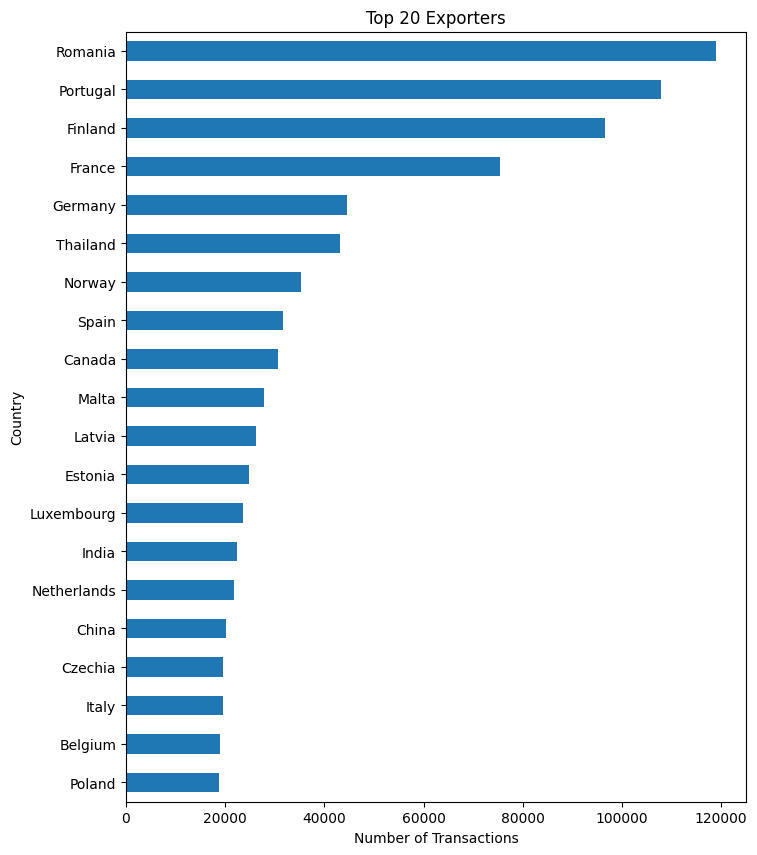

In [43]:
# From df_export
df_export['reporterDesc'].value_counts().head(20).plot(kind='barh', figsize=(8, 10))
plt.title("Top 20 Exporters")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.show()

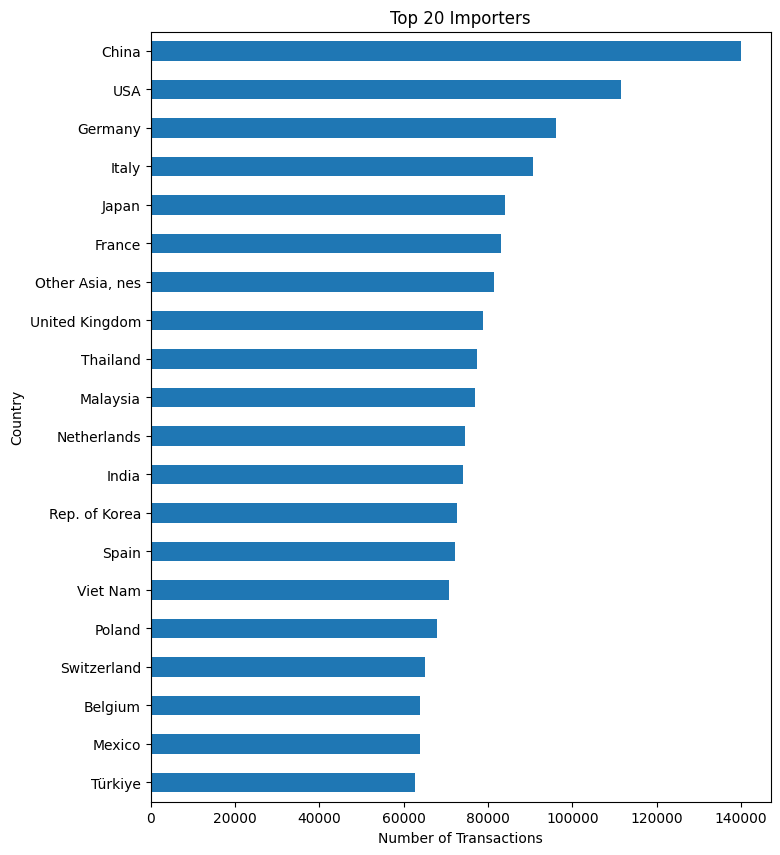

In [44]:
# From df_import
df_import['partnerDesc'].value_counts().head(20).plot(kind='barh', figsize=(8, 10))
plt.title("Top 20 Importers")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.show()

#### Importers

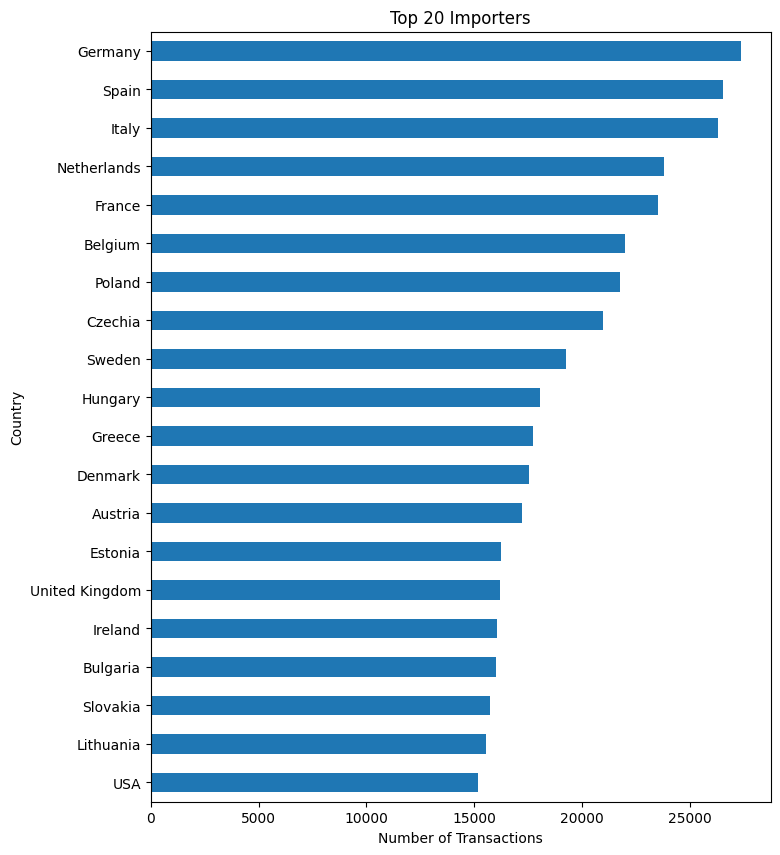

In [45]:
# From df_export
df_export['partnerDesc'].value_counts().head(20).plot(kind='barh', figsize=(8, 10))
plt.title("Top 20 Importers")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.show()

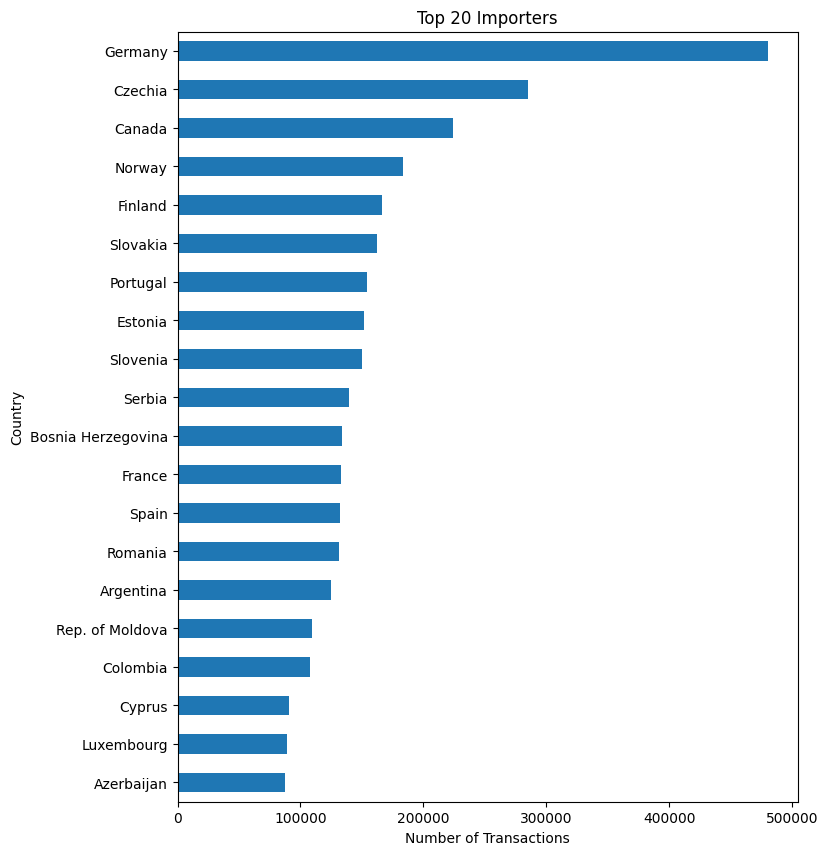

In [46]:
# From df_import
df_import['reporterDesc'].value_counts().head(20).plot(kind='barh', figsize=(8, 10))
plt.title("Top 20 Importers")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.gca().invert_yaxis()
plt.show()

#### Insight:
We can take a data either import or export from both export report or import report. However, we will have some aggregation data from the opposite report such as taking an export data from import report which exporter will be as 'partner' and the 'reporter' will be the import country. The reporter somehow create a aggregation data such as 'World' as their 'partner'. So we have to focus on the 'reporter' only to avoid aggregation data.

# Outlier Check

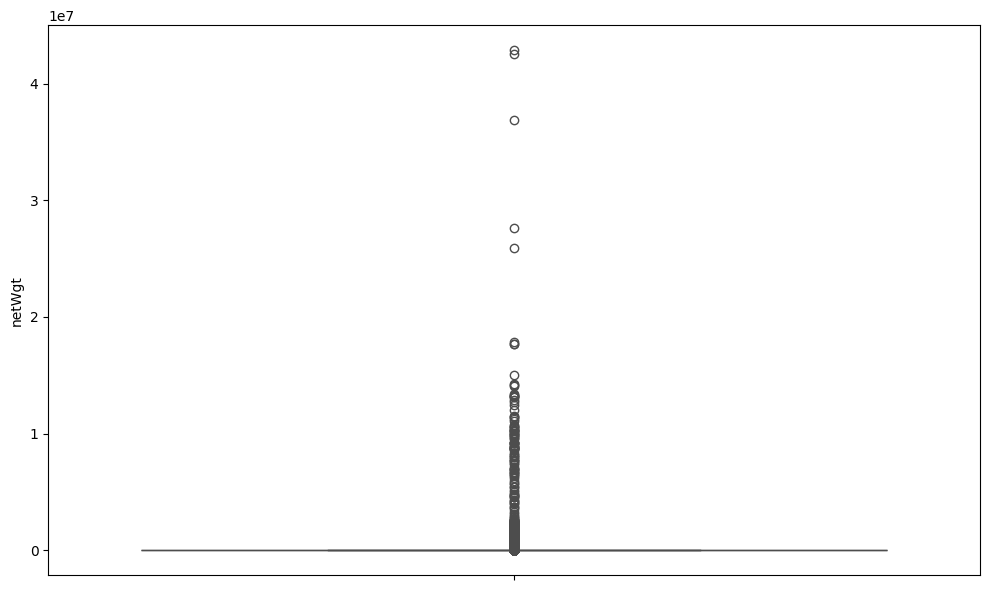

In [47]:
# Check outliers
numerical_columns = df_export.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(10, 6))
for i in range(0, len(numerical_columns)):
    plt.subplot(1,len(numerical_columns), i+1)
    sns.boxplot(y=df_export[numerical_columns[i]], color='blue')
    plt.tight_layout()

Since the operations value is the part that has outliers, we will keep the outliers, to keep the original information.

# Export Data for PBI uses

In [48]:
#df_export.to_excel('df_export.xlsx', index=False)

In [49]:
#df_import.to_excel('df_import.xlsx', index=False)

## Data of the quantity

In [50]:
zero_counts = df_export.apply(lambda x: (x == 0).sum())
print(zero_counts)

reporterCode    0
reporterDesc    0
partnerCode     0
partnerDesc     0
period          0
flowCode        0
flowDesc        0
cmdCode         0
cmdDesc         0
qty             0
fobvalue        0
netWgt          0
dtype: int64


In [51]:
# Drop rows where 'qty' is zero in df_export
df_export_qty = df_export[df_export['qty'] != 0].reset_index(drop=True)
df_export_qty.head()

reporterCode reporterDesc partnerCode               partnerDesc  period  \
0           36    Australia         238  Falkland Isds (Malvinas)  202501   
1           36    Australia          84                    Belize  202501   
2           36    Australia         140      Central African Rep.  202501   
3           36    Australia          90              Solomon Isds  202501   
4           36    Australia         724                     Spain  202501   

  flowCode flowDesc cmdCode                         cmdDesc qty  fobvalue  \
0        X   Export   TOTAL                 All Commodities   0  1289.771   
1        X   Export   TOTAL                 All Commodities   0  2085.918   
2        X   Export   TOTAL                 All Commodities   0    379.71   
3        X   Export    8542  Electronic integrated circuits   0   46541.3   
4        X   Export    8542  Electronic integrated circuits   0   370.373   

        netWgt  
0  1840.650535  
1  1840.650535  
2  1840.650535  
3  1840.650535  
4  1840.650535

In [52]:
zero_counts = df_export_qty.apply(lambda x: (x == 0).sum())
print(zero_counts)

reporterCode    0
reporterDesc    0
partnerCode     0
partnerDesc     0
period          0
flowCode        0
flowDesc        0
cmdCode         0
cmdDesc         0
qty             0
fobvalue        0
netWgt          0
dtype: int64


In [53]:
df_export_qty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491617 entries, 0 to 1491616
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   reporterCode  1491617 non-null  object 
 1   reporterDesc  1491617 non-null  object 
 2   partnerCode   1491617 non-null  object 
 3   partnerDesc   1491617 non-null  object 
 4   period        1491617 non-null  object 
 5   flowCode      1491617 non-null  object 
 6   flowDesc      1491617 non-null  object 
 7   cmdCode       1491617 non-null  object 
 8   cmdDesc       1491617 non-null  object 
 9   qty           1491617 non-null  object 
 10  fobvalue      1491617 non-null  object 
 11  netWgt        1491617 non-null  float64
dtypes: float64(1), object(11)
memory usage: 136.6+ MB


In [54]:
#df_export_qty.to_excel('df_export_qty.xlsx', index=False)

# Data Manipulation

In [55]:
# Select only columns with float or int data types from df_copy_clean
numeric_df = df_export.select_dtypes(include=['float64', 'int64'])
numeric_df.head()

netWgt
0  1840.650535
1  1840.650535
2  1840.650535
3  1840.650535
4  1840.650535

In [56]:
def check_plot(df, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

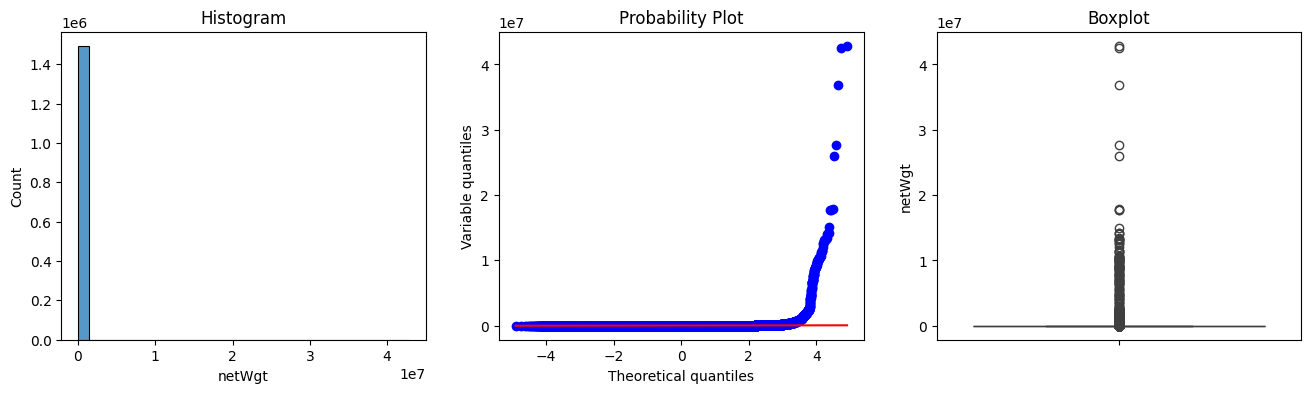

In [57]:
for col in numeric_df:
    check_plot(numeric_df, col)

There is nothing to conclude yet here.

In [58]:
# Convert fobvalue to numeric before aggregation
df_export['fobvalue'] = pd.to_numeric(df_export['fobvalue'], errors='coerce')
top_countries = df_export.groupby('reporterDesc')['fobvalue'].mean().sort_values(ascending=False).reset_index()
top_countries.head(10)

reporterDesc      fobvalue
0                 China  8.452433e+08
1                   USA  5.810808e+08
2               Germany  3.997448e+08
3                Mexico  3.401481e+08
4                 Japan  2.382413e+08
5  China, Hong Kong SAR  2.364053e+08
6         Rep. of Korea  2.270357e+08
7              Viet Nam  2.070602e+08
8                 Italy  1.758185e+08
9           Netherlands  1.748166e+08

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\1022818561.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries.head(10), x='fobvalue', y='reporterDesc', palette='viridis')


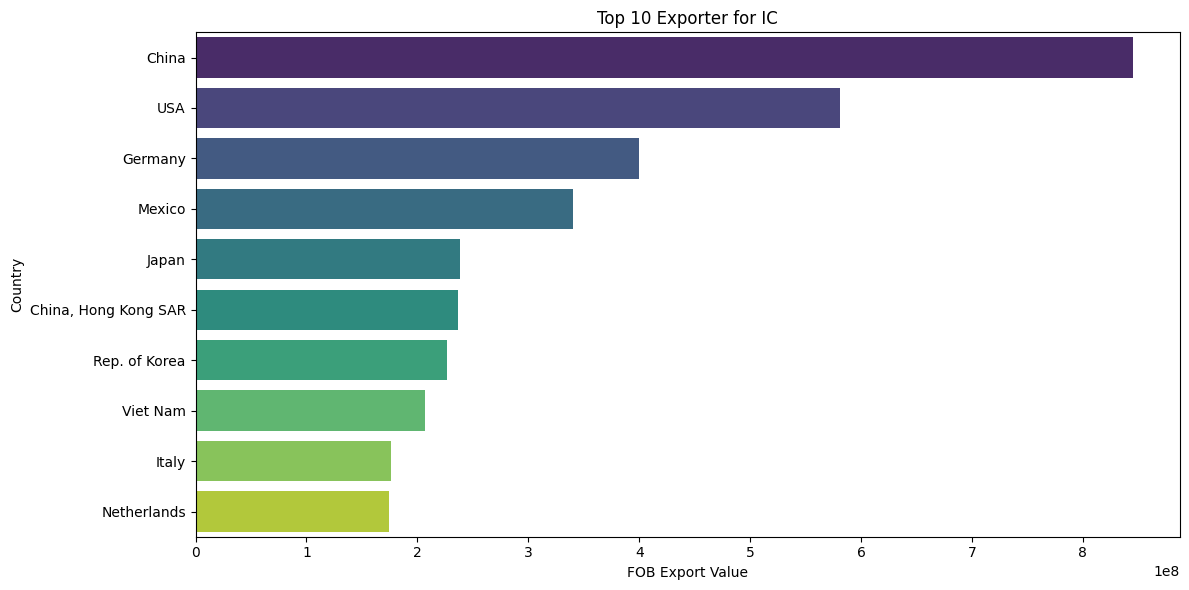

In [59]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top_countries.head(10), x='fobvalue', y='reporterDesc', palette='viridis')
plt.title('Top 10 Exporter for IC')
plt.xlabel('FOB Export Value')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

<Axes: xlabel='period'>

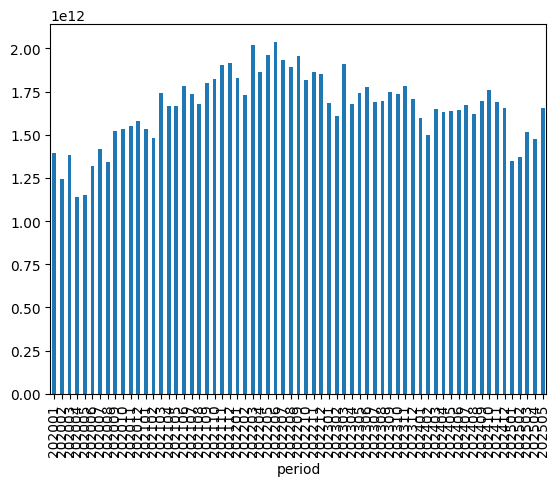

In [60]:
df_export.groupby(['period'])['fobvalue'].sum().plot(kind='bar')

In [61]:
# a. Trend analysis over time
trend_df = df_export.groupby("period")["fobvalue"].sum().reset_index()
trend_df

period      fobvalue
0   202001  1.397013e+12
1   202002  1.245022e+12
2   202003  1.382261e+12
3   202004  1.138963e+12
4   202005  1.151214e+12
..     ...           ...
60  202501  1.347666e+12
61  202502  1.368442e+12
62  202503  1.518198e+12
63  202504  1.478058e+12
64  202505  1.654319e+12

[65 rows x 2 columns]

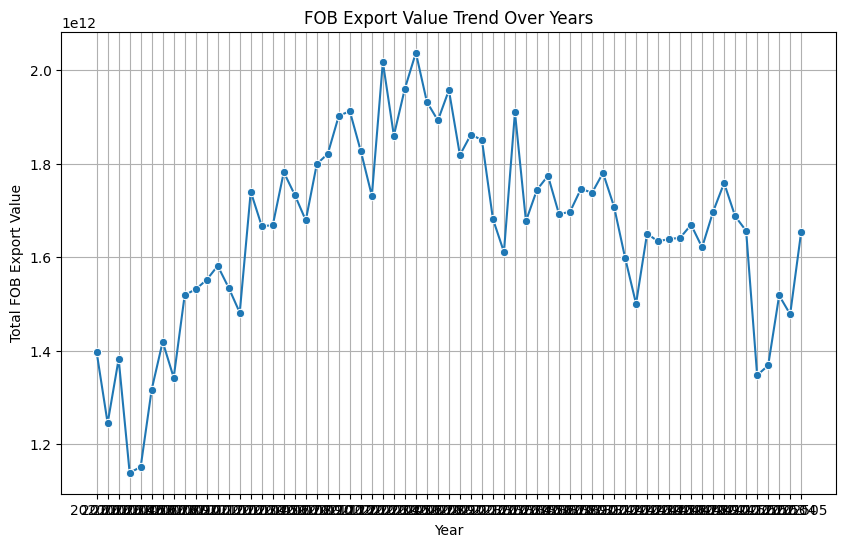

In [62]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_df, x='period', y='fobvalue', marker='o')
plt.title('FOB Export Value Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Total FOB Export Value')
plt.grid(True)
plt.show()

In [63]:
# Calculate export value per kg
df_export["value_per_kg"] = df_export["fobvalue"] / df_export["netWgt"]

In [64]:
# b. Avg export value/kg by country
value_per_kg_df = df_export.groupby("reporterDesc")["value_per_kg"].mean().reset_index()
value_per_kg_df = value_per_kg_df.sort_values(by="value_per_kg", ascending=False).head(20)
value_per_kg_df

reporterDesc   value_per_kg
27                  China  440700.834447
123                   USA  315693.168271
48                Germany  215635.029114
79                 Mexico  184738.347524
61                  Japan  124093.966121
126              Viet Nam  111133.959027
101         Rep. of Korea  106942.061512
28   China, Hong Kong SAR   97128.217550
60                  Italy   96057.486636
25                 Canada   94742.836182
87            Netherlands   94449.345387
104    Russian Federation   94288.190943
108          Saudi Arabia   86275.204762
119           Switzerland   78530.816080
112             Singapore   76194.883932
5               Australia   67750.346225
56                  India   66421.120609
11                Belgium   59964.964291
18                 Brazil   56358.740245
75               Malaysia   55020.620201

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\769833094.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=value_per_kg_df, x='value_per_kg', y='reporterDesc', palette='mako')


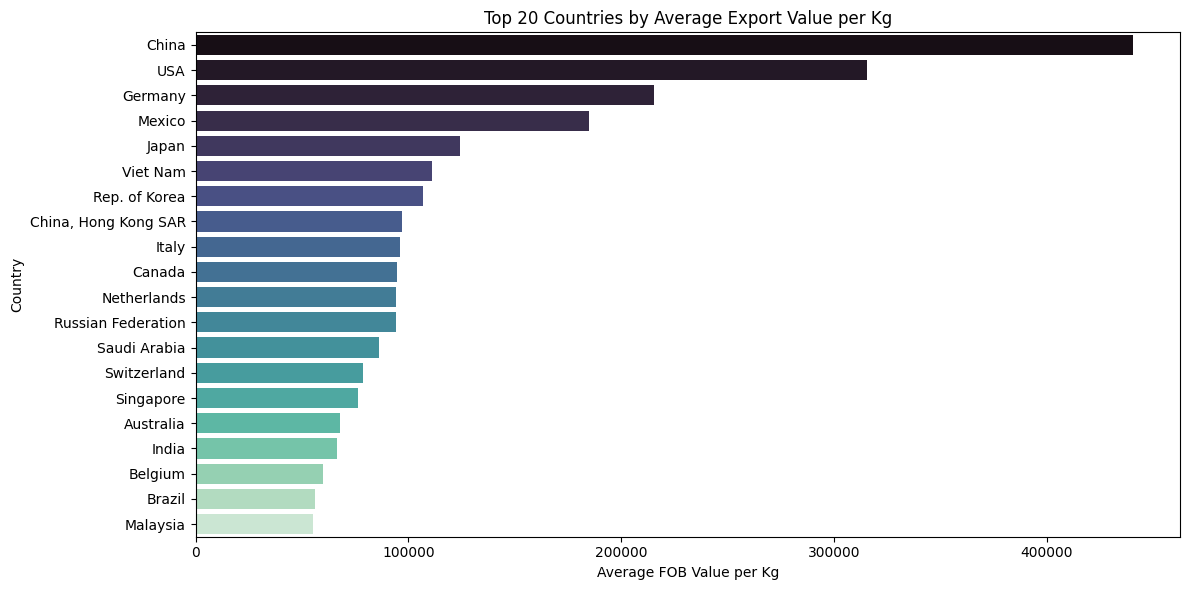

In [65]:
plt.figure(figsize=(12, 6))
sns.barplot(data=value_per_kg_df, x='value_per_kg', y='reporterDesc', palette='mako')
plt.title('Top 20 Countries by Average Export Value per Kg')
plt.xlabel('Average FOB Value per Kg')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [66]:
importer_value_per_kg_df = df_export.groupby("partnerDesc").agg(
    total_fobvalue=("fobvalue", "sum"),
    total_netwgt=("netWgt", "sum")
).reset_index()

In [67]:
# Calculate value per kg
importer_value_per_kg_df["value_per_kg"] = (
    importer_value_per_kg_df["total_fobvalue"] / importer_value_per_kg_df["total_netwgt"]
)
importer_value_per_kg_df = importer_value_per_kg_df.sort_values(by="value_per_kg", ascending=False).head(20)


C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\491785898.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importer_value_per_kg_df, x='value_per_kg', y='partnerDesc', palette='mako')
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\491785898.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=value_per_kg_df, x='value_per_kg', y='reporterDesc', palette='mako')


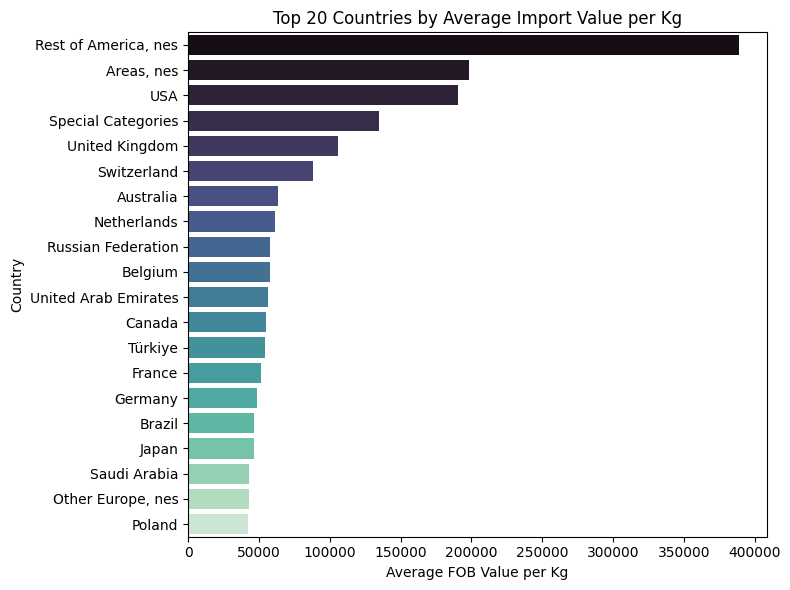

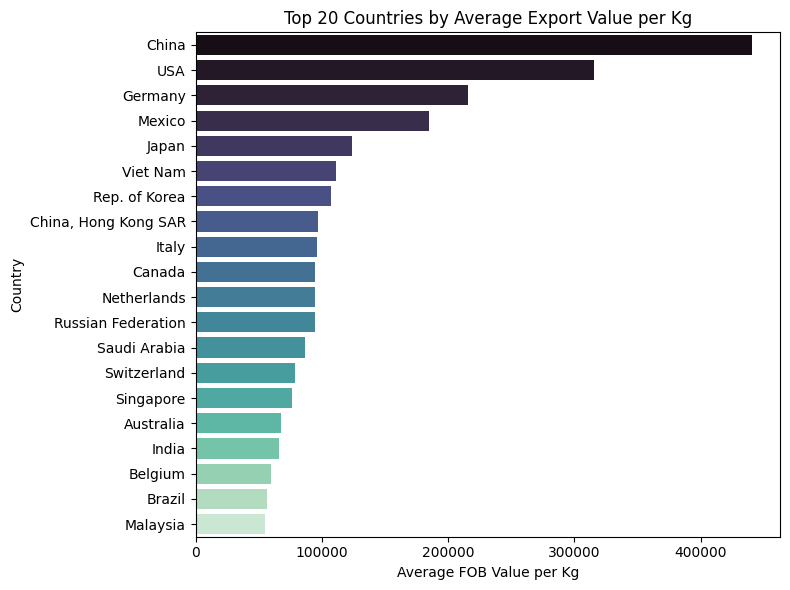

In [68]:
plt.figure(figsize=(8, 6))
sns.barplot(data=importer_value_per_kg_df, x='value_per_kg', y='partnerDesc', palette='mako')
plt.title('Top 20 Countries by Average Import Value per Kg')
plt.xlabel('Average FOB Value per Kg')
plt.ylabel('Country')
plt.tight_layout()

plt.figure(figsize=(8, 6))
sns.barplot(data=value_per_kg_df, x='value_per_kg', y='reporterDesc', palette='mako')
plt.title('Top 20 Countries by Average Export Value per Kg')
plt.xlabel('Average FOB Value per Kg')
plt.ylabel('Country')
plt.tight_layout()

plt.show()

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\101735088.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_importers_filtered, y="partnerDesc", x="value_per_kg", palette="viridis")


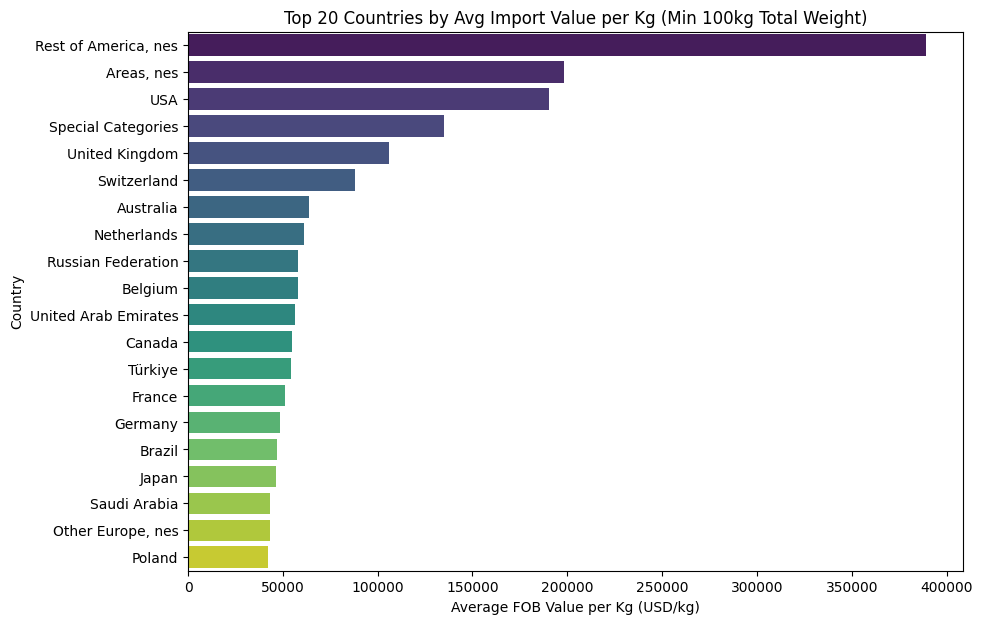

In [69]:
# Apply threshold: remove countries with too small total weight (e.g., <100kg)
filtered_df = importer_value_per_kg_df[importer_value_per_kg_df["total_netwgt"] > 100]

# Get top 20 by FOB value
top_importers_filtered = filtered_df.sort_values(by="value_per_kg", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(data=top_importers_filtered, y="partnerDesc", x="value_per_kg", palette="viridis")
plt.title("Top 20 Countries by Avg Import Value per Kg (Min 100kg Total Weight)")
plt.xlabel("Average FOB Value per Kg (USD/kg)")
plt.ylabel("Country")
plt.show()


Move to PBI to make a complete visualization, and conclusion. Business recommendation is in Powerpoint.

In [70]:
# Top exporters by FOB
top_exp = (df_copy_export.groupby('reporterDesc')['fobvalue']
                 .sum().sort_values(ascending=False).head(10))

# Convert netWgt and fobvalue to numeric
df_copy_export['netWgt'] = pd.to_numeric(df_copy_export['netWgt'], errors='coerce')
df_copy_export['fobvalue'] = pd.to_numeric(df_copy_export['fobvalue'], errors='coerce')

# Weighted $/kg with a weight floor (e.g., 1,000 kg)
g = df_copy_export[(df_copy_export['netWgt'] > 0) & (df_copy_export['fobvalue'] > 0)] \
        .groupby('reporterDesc').agg(val=('fobvalue','sum'),
                                     wgt=('netWgt','sum'))
g['usd_per_kg'] = g['val'] / g['wgt']
price_rank = g[g['wgt'] >= 1000].sort_values('usd_per_kg', ascending=False).head(10)

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\535947027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_export['netWgt'] = pd.to_numeric(df_copy_export['netWgt'], errors='coerce')
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\535947027.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_export['fobvalue'] = pd.to_numeric(df_copy_export['fobvalue'], errors='coerce')


x value (usd_per_kg):
reporterDesc
USA                   315693.168271
Mexico                177998.085347
Russian Federation    106947.065841
Switzerland           103552.228087
Germany               101090.112811
Canada                 95045.983994
Saudi Arabia           82866.611028
Italy                  77483.976190
Australia              69182.611463
China                  67174.177959
Name: usd_per_kg, dtype: float64


C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2912927662.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=price_rank, x='usd_per_kg', y=price_rank.index, palette="viridis")
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2912927662.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


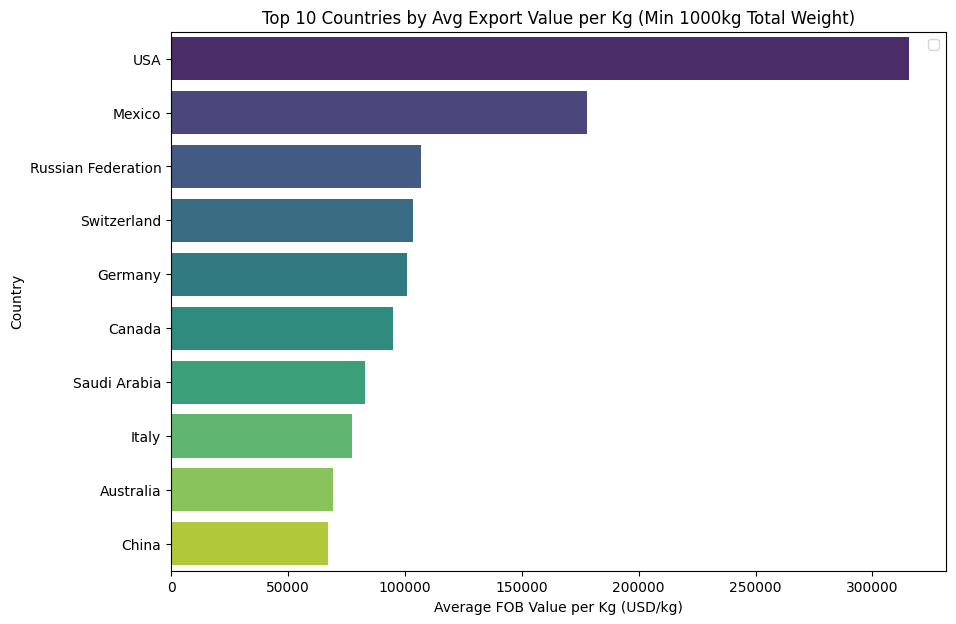

In [71]:
# Plot
plt.figure(figsize=(10, 7))
sns.barplot(data=price_rank, x='usd_per_kg', y=price_rank.index, palette="viridis")
plt.title("Top 10 Countries by Avg Export Value per Kg (Min 1000kg Total Weight)")
plt.xlabel("Average FOB Value per Kg (USD/kg)")
plt.ylabel("Country")
plt.legend()
print("x value (usd_per_kg):")
print(price_rank['usd_per_kg'])
plt.show()

# Machine learning

In [77]:

monthly = (
    df_export.groupby('period')['fobvalue']
    .sum()
    .reset_index()
    .rename(columns={'period': 'ref_date', 'fobvalue': 'total_value'})
)
monthly['ref_date'] = pd.to_datetime(monthly['ref_date'], format='%Y%m')

components, forecast_6, seasonal_indices, meta = decomp_forecast_multiplicative_flex(
    monthly, value_col="total_value", ma_window=6, season=6, horizon=6
)

In [ ]:
hist_tbl = components.reset_index().copy()
hist_tbl["month_label"] = hist_tbl["ref_date"].dt.strftime("%Y-%m")
future_tbl = forecast_6.copy()
future_tbl["month_label"] = future_tbl["ref_date"].dt.strftime("%Y-%m")
table_full = pd.concat([
    hist_tbl[["ref_date","month_label","Actual","CMA","SI","Deseasonalized","Trend(a+bt)","LTwS_fitted"]],
    future_tbl[["ref_date","month_label","Trend(a+bt)_future","SI_future","Forecast_LTwS"]]
], ignore_index=True).sort_values("ref_date").reset_index(drop=True)

print(f"Using metric: {value_col}  (set value_col='total_kg' for Net Weight)")
print(f"Linear trend: y = a + b*t,  a={meta['intercept_a']:.3g},  b={meta['slope_b']:.3g}")
print(f"MAD LT (Actual vs Trend):       {meta['MAD_LT']:.3g}")
print(f"MAD LTwS (Actual vs Trend*SI):  {meta['MAD_LTwS']:.3g}")

display(table_full.tail(20))  

Using metric: total_value  (set value_col='total_kg' for Net Weight)
Linear trend: y = a + b*t,  a=1.58e+12,  b=2.43e+09
MAD LT (Actual vs Trend):       1.53e+11
MAD LTwS (Actual vs Trend*SI):  1.48e+11


ref_date month_label        Actual           CMA        SI  \
51 2024-04-01     2024-04  1.633990e+12  1.633794e+12  1.001159   
52 2024-05-01     2024-05  1.639077e+12  1.616429e+12  1.015888   
53 2024-06-01     2024-06  1.641475e+12  1.616689e+12  1.023659   
54 2024-07-01     2024-07  1.669564e+12  1.632589e+12  0.977007   
55 2024-08-01     2024-08  1.621239e+12  1.646568e+12  0.944011   
56 2024-09-01     2024-09  1.697593e+12  1.660888e+12  1.038275   
57 2024-10-01     2024-10  1.758772e+12  1.675367e+12  1.001159   
58 2024-11-01     2024-11  1.688035e+12  1.680699e+12  1.015888   
59 2024-12-01     2024-12  1.656509e+12  1.655127e+12  1.023659   
60 2025-01-01     2025-01  1.347666e+12  1.607236e+12  0.977007   
61 2025-02-01     2025-02  1.368442e+12  1.571220e+12  0.944011   
62 2025-03-01     2025-03  1.518198e+12  1.532877e+12  1.038275   
63 2025-04-01     2025-04  1.478058e+12  1.506675e+12  1.001159   
64 2025-05-01     2025-05  1.654319e+12           NaN  1.015888   
65 2025-06-01     2025-06           NaN           NaN       NaN   
66 2025-07-01     2025-07           NaN           NaN       NaN   
67 2025-08-01     2025-08           NaN           NaN       NaN   
68 2025-09-01     2025-09           NaN           NaN       NaN   
69 2025-10-01     2025-10           NaN           NaN       NaN   
70 2025-11-01     2025-11           NaN           NaN       NaN   

    Deseasonalized   Trend(a+bt)   LTwS_fitted  Trend(a+bt)_future  SI_future  \
51    1.632098e+12  1.707224e+12  1.709202e+12                 NaN        NaN   
52    1.613442e+12  1.709657e+12  1.736821e+12                 NaN        NaN   
53    1.603537e+12  1.712090e+12  1.752597e+12                 NaN        NaN   
54    1.708855e+12  1.714523e+12  1.675101e+12                 NaN        NaN   
55    1.717394e+12  1.716956e+12  1.620825e+12                 NaN        NaN   
56    1.635013e+12  1.719389e+12  1.785198e+12                 NaN        NaN   
57    1.756736e+12  1.721822e+12  1.723817e+12                 NaN        NaN   
58    1.661634e+12  1.724255e+12  1.751651e+12                 NaN        NaN   
59    1.618222e+12  1.726688e+12  1.767540e+12                 NaN        NaN   
60    1.379382e+12  1.729121e+12  1.689364e+12                 NaN        NaN   
61    1.449604e+12  1.731554e+12  1.634606e+12                 NaN        NaN   
62    1.462231e+12  1.733987e+12  1.800354e+12                 NaN        NaN   
63    1.476347e+12  1.736420e+12  1.738432e+12                 NaN        NaN   
64    1.628445e+12  1.738853e+12  1.766480e+12                 NaN        NaN   
65             NaN           NaN           NaN        1.741286e+12   1.023659   
66             NaN           NaN           NaN        1.743719e+12   0.977007   
67             NaN           NaN           NaN        1.746152e+12   0.944011   
68             NaN           NaN           NaN        1.748585e+12   1.038275   
69             NaN           NaN           NaN        1.751017e+12   1.001159   
70             NaN           NaN           NaN        1.753450e+12   1.015888   

    Forecast_LTwS  
51            NaN  
52            NaN  
53            NaN  
54            NaN  
55            NaN  
56            NaN  
57            NaN  
58            NaN  
59            NaN  
60            NaN  
61            NaN  
62            NaN  
63            NaN  
64            NaN  
65   1.782483e+12  
66   1.703626e+12  
67   1.648387e+12  
68   1.815511e+12  
69   1.753047e+12  
70   1.781310e+12

c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\1450298119.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds_reg.append(float(m.predict(X_1)))
c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\

MAE          RMSE      MAPE%
SNaive12                 1.453650e+11  1.682135e+11   8.423396
Trend+Seasonality (Reg)  2.305839e+11  2.513635e+11  13.840486

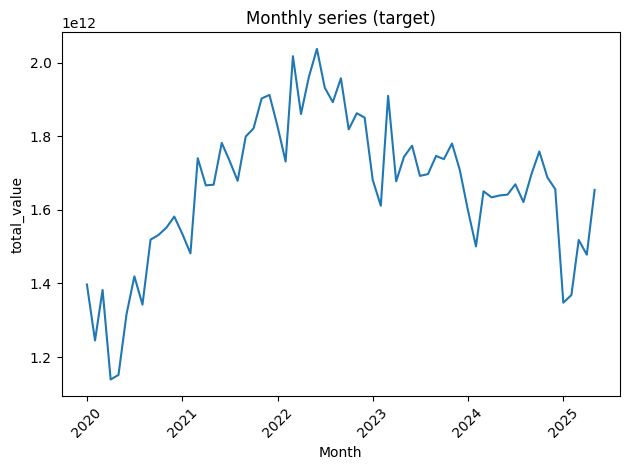

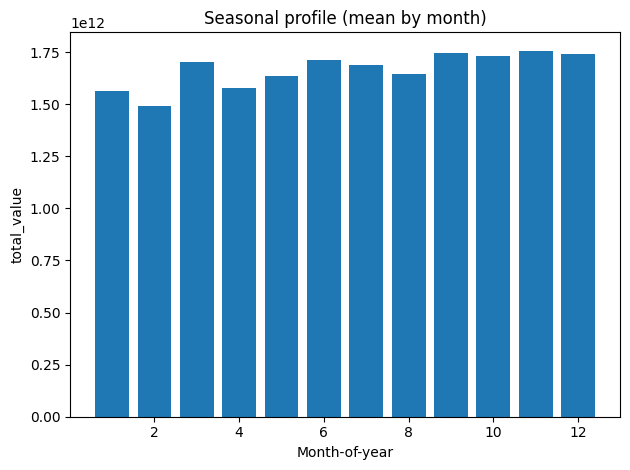

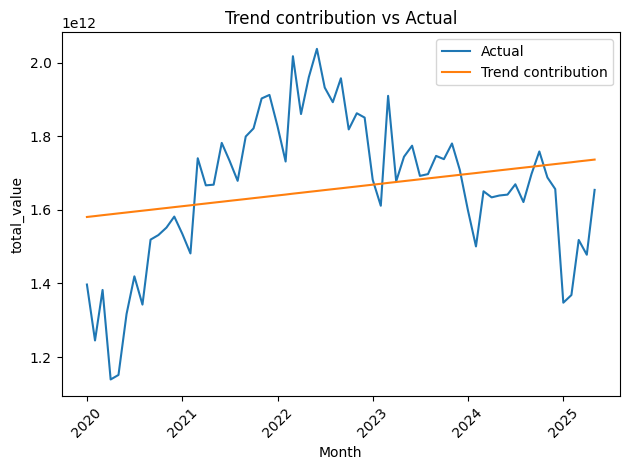

c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


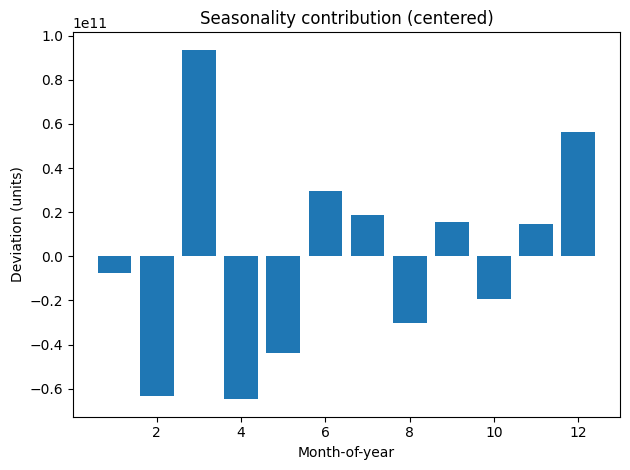

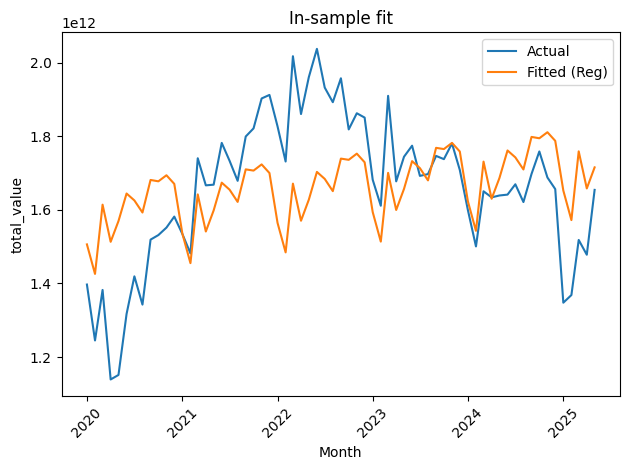

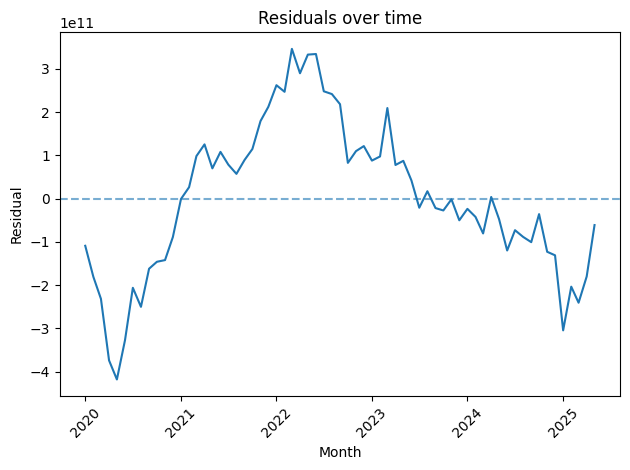

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\1450298119.py:140: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(res_by_m, labels=list(range(1,13)), showmeans=True)


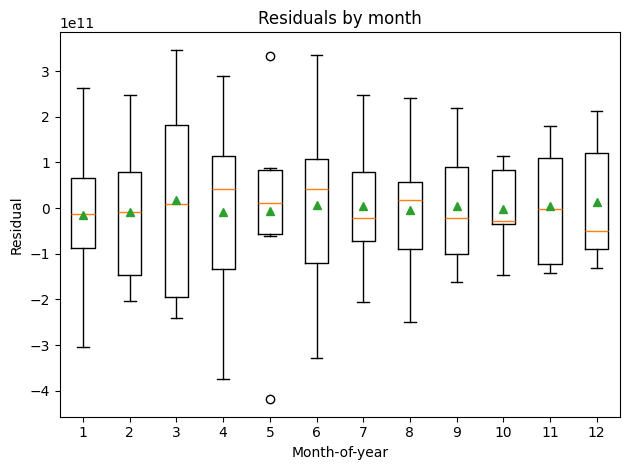

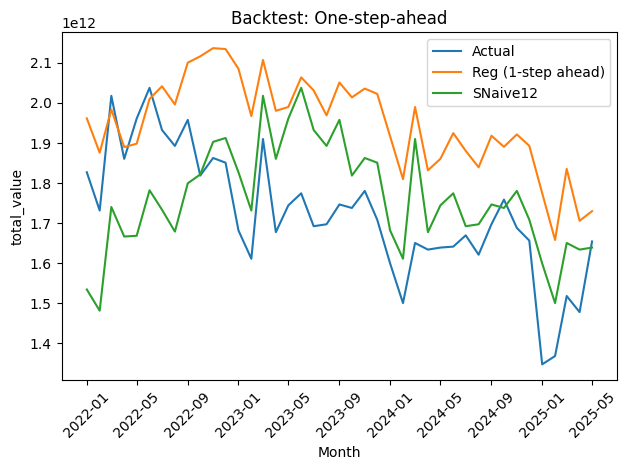

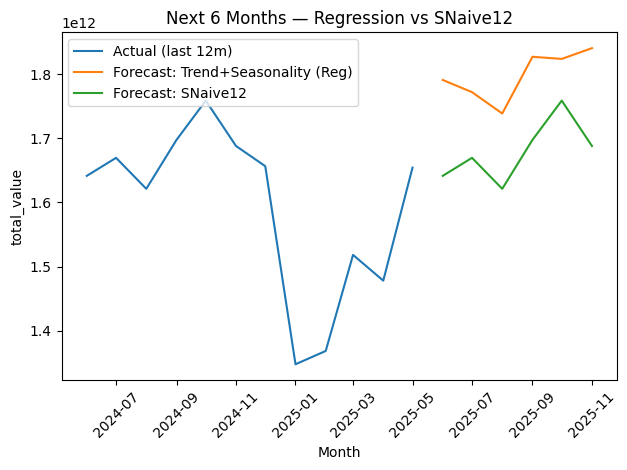

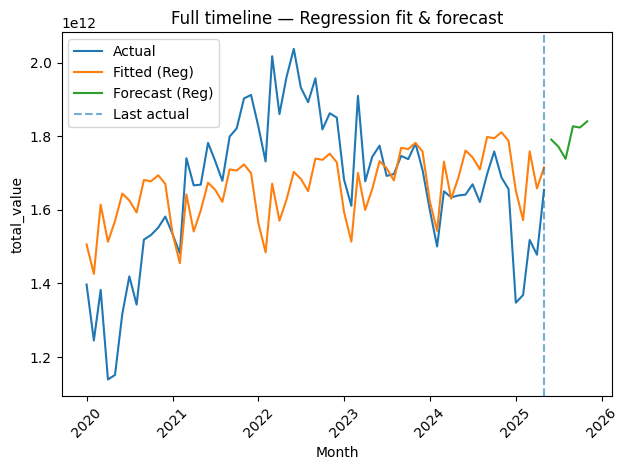

=== Months (last 12) ===
2020-01
2020-02
2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03
2023-04
2023-05
2023-06
2023-07
2023-08
2023-09
2023-10
2023-11
2023-12
2024-01
2024-02
2024-03
2024-04
2024-05
2024-06
2024-07
2024-08
2024-09
2024-10
2024-11
2024-12
2025-01
2025-02
2025-03
2025-04
2025-05

=== Values (last 12) ===
1,397,013,010,009
1,245,021,766,680
1,382,261,022,822
1,138,962,564,287
1,151,213,903,774
1,316,931,237,035
1,419,288,821,583
1,342,454,881,969
1,519,087,115,365
1,531,474,185,886
1,551,796,662,393
1,581,732,938,651
1,534,510,219,127
1,481,583,155,422
1,740,344,715,309
1,666,653,154,291
1,668,474,511,886
1,782,057,739,395
1,733,480,989,831
1,678,907,188,148
1,799,426,452,185
1,821,528,684,083
1,902,872,084,206
1,912,480,413,4

In [79]:
value_col = "total_value"     
H         = 6              
use_ridge = True             
fourier_order = 2          

y = (monthly[["ref_date", value_col]]
     .dropna().sort_values("ref_date")
     .set_index("ref_date")[value_col]
     .asfreq("MS"))

additional = []
if fourier_order > 0:
    additional = [CalendarFourier(freq="A", order=fourier_order)]

dp = DeterministicProcess(
    index=y.index,
    constant=True,    
    order=1,         
    seasonal=True,     
    additional_terms=additional,
    drop=True
)
X   = dp.in_sample()
X_f = dp.out_of_sample(steps=H)

Model = Ridge(alpha=1.0) if use_ridge else LinearRegression()
Model.fit(X, y)
y_fit = pd.Series(Model.predict(X), index=y.index, name="Fitted")
y_fc  = pd.Series(Model.predict(X_f), index=X_f.index, name="Forecast")

def snaive12(series, steps):
    last12 = series.iloc[-12:]
    reps = int(np.ceil(steps/12))
    return pd.Series(np.tile(last12.values, reps)[:steps],
                     index=pd.date_range(series.index[-1] + pd.offsets.MonthBegin(1), periods=steps, freq="MS"))
y_fc_snaive = snaive12(y.dropna(), H).rename("SNaive12")

def expanding_backtest(y, min_train=24):
    preds_reg, preds_sna, actuals = [], [], []
    idxs = []
    for t in range(min_train, len(y)):
        y_tr = y.iloc[:t]  
        dp_tr = DeterministicProcess(
            index=y_tr.index, constant=True, order=1, seasonal=True,
            additional_terms=[CalendarFourier("A", fourier_order)] if fourier_order>0 else None, drop=True
        )
        X_tr = dp_tr.in_sample()
        X_1  = dp_tr.out_of_sample(steps=1)

        m = Ridge(alpha=1.0) if use_ridge else LinearRegression()
        m.fit(X_tr, y_tr)
        preds_reg.append(float(m.predict(X_1)))

        preds_sna.append(float(y.iloc[t-12] if t >= 12 else y_tr.iloc[-1]))

        actuals.append(float(y.iloc[t]))
        idxs.append(y.index[t])

    return (pd.Series(preds_reg, index=idxs, name="Reg(1-step)"),
            pd.Series(preds_sna, index=idxs, name="SNaive12"),
            pd.Series(actuals, index=idxs, name="Actual"))

min_train = max(24, 12) 
reg_bt, sna_bt, act_bt = expanding_backtest(y.dropna(), min_train=min_train)

def metrics(y_true, y_pred):
    yt, yp = pd.Series(y_true).astype(float).align(pd.Series(y_pred).astype(float), join="inner")
    yt, yp = yt.dropna(), yp.dropna()
    # MAE
    mae = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    denom = yt.replace(0, np.nan)
    mape = (np.abs((yt - yp) / denom)).dropna().mean() * 100
    return pd.Series({"MAE": mae, "RMSE": rmse, "MAPE%": mape})

leaderboard = pd.concat([
    metrics(act_bt, reg_bt).rename("Trend+Seasonality (Reg)"),
    metrics(act_bt, sna_bt).rename("SNaive12"),
], axis=1).T.sort_values("RMSE")

display(leaderboard)


# 1) Raw series
plt.figure()
plt.plot(y.index, y.values)
plt.title("Monthly series (target)"); plt.xlabel("Month"); plt.ylabel(value_col)
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# 2) Seasonal profile (mean by month-of-year)
moy = y.groupby(y.index.month).mean()
plt.figure()
plt.bar(range(1,13), moy.values)
plt.title("Seasonal profile (mean by month)"); plt.xlabel("Month-of-year"); plt.ylabel(value_col)
plt.tight_layout(); plt.show()

# 3) Trend contribution (from the regression)
coef = pd.Series(Model.coef_, index=X.columns)
intercept = Model.intercept_
trend_col = [c for c in X.columns if "trend" in c or c.endswith("order 1") or c.startswith("trend")]
trend_part = intercept + (X[trend_col] @ coef[trend_col])
plt.figure()
plt.plot(y.index, y.values, label="Actual")
plt.plot(y.index, trend_part.values, label="Trend contribution")
plt.title("Trend contribution vs Actual"); plt.xlabel("Month"); plt.ylabel(value_col)
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# 4) Seasonal contribution shape over a canonical year
months = pd.date_range("2000-01-01", periods=12, freq="MS")
dp_season = DeterministicProcess(
    index=months, constant=True, order=0, seasonal=True,
    additional_terms=[CalendarFourier("A", fourier_order)] if fourier_order>0 else None, drop=True
)
Xs = dp_season.in_sample()
season_cols = [c for c in Xs.columns if c not in ["const"]]  
season_effect = Model.intercept_ + (Xs[season_cols] @ coef.reindex(season_cols).fillna(0))
season_effect = season_effect - season_effect.mean() 
plt.figure()
plt.bar(range(1,13), season_effect.values)
plt.title("Seasonality contribution (centered)"); plt.xlabel("Month-of-year"); plt.ylabel("Deviation (units)")
plt.tight_layout(); plt.show()

# 5) Fitted vs Actual (in-sample)
plt.figure()
plt.plot(y.index, y.values, label="Actual")
plt.plot(y_fit.index, y_fit.values, label="Fitted (Reg)")
plt.title("In-sample fit"); plt.xlabel("Month"); plt.ylabel(value_col)
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# 6) Residuals diagnostics: time plot and box by month
res = (y - y_fit).dropna()
plt.figure()
plt.plot(res.index, res.values)
plt.axhline(0, linestyle="--", alpha=0.6)
plt.title("Residuals over time"); plt.xlabel("Month"); plt.ylabel("Residual")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure()
res_by_m = [res[res.index.month==m].values for m in range(1,13)]
plt.boxplot(res_by_m, labels=list(range(1,13)), showmeans=True)
plt.title("Residuals by month"); plt.xlabel("Month-of-year"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# 7) Backtest curve (1-step ahead)
plt.figure()
plt.plot(act_bt.index, act_bt.values, label="Actual")
plt.plot(reg_bt.index, reg_bt.values, label="Reg (1-step ahead)")
plt.plot(sna_bt.index, sna_bt.values, label="SNaive12")
plt.title("Backtest: One-step-ahead")
plt.xlabel("Month"); plt.ylabel(value_col); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# 8) Forecast vs last 12m
plt.figure()
plt.plot(y.tail(12).index, y.tail(12).values, label="Actual (last 12m)")
plt.plot(y_fc.index, y_fc.values, label="Forecast: Trend+Seasonality (Reg)")
plt.plot(y_fc_snaive.index, y_fc_snaive.values, label="Forecast: SNaive12")
plt.title("Next 6 Months — Regression vs SNaive12")
plt.xlabel("Month"); plt.ylabel(value_col); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

# 9) Full timeline (fit + forecast)
last_actual = y.index.max()
plt.figure()
plt.plot(y.index, y.values, label="Actual")
plt.plot(y_fit.index, y_fit.values, label="Fitted (Reg)")
plt.plot(y_fc.index, y_fc.values, label="Forecast (Reg)")
plt.axvline(last_actual, linestyle="--", alpha=0.6, label="Last actual")
plt.title("Full timeline — Regression fit & forecast")
plt.xlabel("Month"); plt.ylabel(value_col); plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()
# =================================================================================================

tbl = (
    y.asfreq("MS")              
     .to_frame(name=value_col)   
     .reset_index()
)
tbl.columns = ["Month", value_col]
tbl["MonthStr"] = tbl["Month"].dt.strftime("%Y-%m")

print("=== Months (last 12) ===")
print(tbl["MonthStr"].to_string(index=False))

print("\n=== Values (last 12) ===")
print(tbl[value_col].apply(lambda v: f"{v:,.0f}").to_string(index=False))

In [83]:
moy = y.asfreq("MS").groupby(y.index.month).mean()
moy = moy.reindex(range(1, 13))  

months_s = pd.Series([calendar.month_abbr[m] for m in moy.index], name="Month")
values_s = pd.Series(moy.values, name=value_col)

print("=== Months (Jan..Dec) ===")
print(months_s.to_string(index=False))

print("\n=== Mean by month (same order) ===")
print(values_s.apply(lambda v: "-" if pd.isna(v) else f"{v:,.0f}").to_string(index=False))

=== Months (Jan..Dec) ===
Jan
Feb
Mar
Apr
May
Jun
Jul
Aug
Sep
Oct
Nov
Dec

=== Mean by month (same order) ===
1,564,584,275,321
1,489,708,637,519
1,703,170,736,255
1,575,934,247,995
1,636,392,698,664
1,710,525,295,063
1,689,430,593,732
1,646,507,737,887
1,744,108,400,125
1,733,676,179,564
1,757,161,915,287
1,742,007,376,717


In [84]:
t = pd.Series(np.arange(1, len(y)+1), index=y.index, name="t")


b, a = np.polyfit(t, y.values, 1)   

trend_lin = pd.Series(a + b*t, index=y.index, name="Trend")

print(f"Linear trend (y ≈ a + b·t):")
print(f"  a (intercept) : {a:,.0f}")
print(f"  b (slope/mo)  : {b:,.0f}")
print(f"  slope/yr      : {b*12:,.0f}")

tbl = pd.DataFrame({"Trend": trend_lin.values})
print("\n=== Month–Trend (last 12) ===")
print(tbl.to_string(index=False,
                             formatters={"Trend": lambda v: f"{v:,.0f}"}))

Linear trend (y ≈ a + b·t):
  a (intercept) : 1,576,833,409,705
  b (slope/mo)  : 2,536,904,166
  slope/yr      : 30,442,849,989

=== Month–Trend (last 12) ===
            Trend
1,579,370,313,871
1,581,907,218,036
1,584,444,122,202
1,586,981,026,368
1,589,517,930,534
1,592,054,834,699
1,594,591,738,865
1,597,128,643,031
1,599,665,547,197
1,602,202,451,363
1,604,739,355,528
1,607,276,259,694
1,609,813,163,860
1,612,350,068,026
1,614,886,972,191
1,617,423,876,357
1,619,960,780,523
1,622,497,684,689
1,625,034,588,855
1,627,571,493,020
1,630,108,397,186
1,632,645,301,352
1,635,182,205,518
1,637,719,109,683
1,640,256,013,849
1,642,792,918,015
1,645,329,822,181
1,647,866,726,347
1,650,403,630,512
1,652,940,534,678
1,655,477,438,844
1,658,014,343,010
1,660,551,247,175
1,663,088,151,341
1,665,625,055,507
1,668,161,959,673
1,670,698,863,838
1,673,235,768,004
1,675,772,672,170
1,678,309,576,336
1,680,846,480,502
1,683,383,384,667
1,685,920,288,833
1,688,457,192,999
1,690,994,097,165
1,693,531,00

c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is d

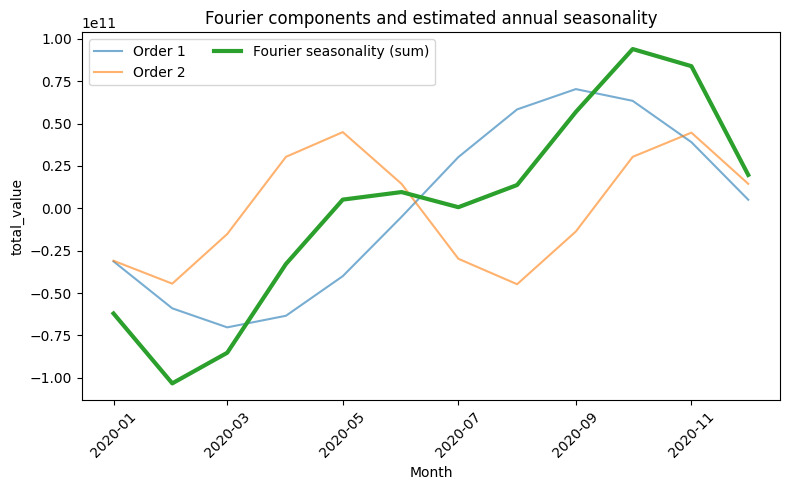

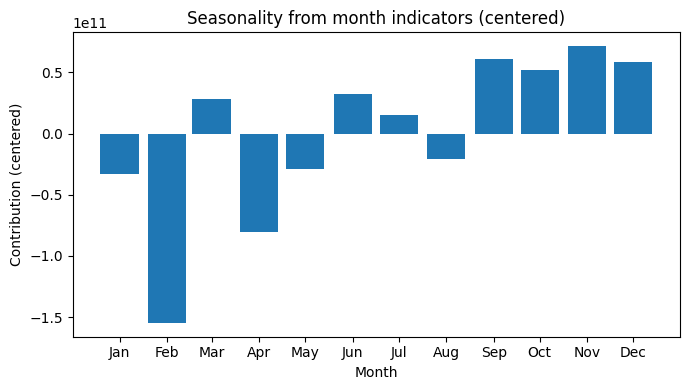

Fourier pairs (scaled):
Order 1: -63155576807.31·sin(2π·1·t/12) + -31323932344.80·cos(2π·1·t/12)
Order 2: -33685644803.66·sin(2π·2·t/12) + -30957667950.27·cos(2π·2·t/12)


In [85]:
def fit_fourier_only(y, order=1, use_ridge=True, alpha=1.0):
    dpF = DeterministicProcess(
        index=y.index,
        constant=False,        
        order=0,           
        seasonal=False,       
        additional_terms=[CalendarFourier("A", order=order)],
        drop=False,
    )
    XF = dpF.in_sample()
    model = Ridge(alpha=alpha) if use_ridge else LinearRegression()
    model.fit(XF, y)
    return dpF, XF, model

# helper: design for a single "template" year (12 points, Jan..Dec) 
def one_year_index(anchor_year=2020):
    return pd.date_range(f"{anchor_year}-01-01", periods=12, freq="MS")

def fourier_design_for_year(order, idx_year):
    dpF_year = DeterministicProcess(
        index=idx_year,
        constant=False,
        order=0,
        seasonal=False,
        additional_terms=[CalendarFourier("A", order=order)],
        drop=False,
    )
    return dpF_year.in_sample()

# 1) Fit Fourier-only on your series 
K = max(1, int(fourier_order))   # ensure at least 1 if you asked for Fourier
dpF, XF, Fmodel = fit_fourier_only(y, order=K, use_ridge=use_ridge, alpha=1.0)

coef = pd.Series(Fmodel.coef_, index=XF.columns)

# 2) Build curves for one canonical year 
idxY = one_year_index()
XF_year = fourier_design_for_year(K, idxY)

basis_curves = {}
for c in XF_year.columns:
    basis_curves[c] = XF_year[c] * coef.get(c, 0.0)

pair_curves = []
labels = []
for k in range(1, K+1):
    sin_col = [c for c in XF_year.columns if f"sin({k}" in c][0]
    cos_col = [c for c in XF_year.columns if f"cos({k}" in c][0]
    curve_k = basis_curves[sin_col] + basis_curves[cos_col]
    pair_curves.append(curve_k)
    labels.append(f"{k}: {coef[sin_col]:.0f}·sin + {coef[cos_col]:.0f}·cos")

seasonality_fourier = pd.concat(pair_curves, axis=1).sum(axis=1)
seasonality_fourier = seasonality_fourier - seasonality_fourier.mean()

#  3) Month-indicator seasonality for comparison 


def fit_fourier_only(y, order=1, use_ridge=True, alpha=1.0):
    dpF = DeterministicProcess(
        index=y.index,
        constant=False,         
        order=0,               
        seasonal=False,        
        additional_terms=[CalendarFourier("A", order=order)],
        drop=False,
    )
    XF = dpF.in_sample()
    model = Ridge(alpha=alpha) if use_ridge else LinearRegression()
    model.fit(XF, y)
    return dpF, XF, model

def one_year_index(anchor_year=2020):
    return pd.date_range(f"{anchor_year}-01-01", periods=12, freq="MS")

def fourier_design_for_year(order, idx_year):
    dpF_year = DeterministicProcess(
        index=idx_year,
        constant=False,
        order=0,
        seasonal=False,
        additional_terms=[CalendarFourier("A", order=order)],
        drop=False,
    )
    return dpF_year.in_sample()

# 1) Fourier-only fit 
K = max(1, int(fourier_order))  
dpF, XF, Fmodel = fit_fourier_only(y, order=K, use_ridge=use_ridge, alpha=1.0)
coef = pd.Series(Fmodel.coef_, index=XF.columns)

idxY = one_year_index()
XF_year = fourier_design_for_year(K, idxY)

pair_curves, labels = [], []
for k in range(1, K+1):
    sin_col = [c for c in XF_year.columns if f"sin({k}" in c][0]
    cos_col = [c for c in XF_year.columns if f"cos({k}" in c][0]
    curve_k = XF_year[sin_col]*coef.get(sin_col,0.0) + XF_year[cos_col]*coef.get(cos_col,0.0)
    pair_curves.append(curve_k.rename(f"order{k}"))
    labels.append(f"Order {k}")

seasonality_fourier = pd.concat(pair_curves, axis=1).sum(axis=1)
seasonality_fourier = seasonality_fourier - seasonality_fourier.mean()

# 2) Month-indicator seasonality (no trend, no Fourier) 
dpM = DeterministicProcess(
    index=y.index,
    constant=True,
    order=0,
    seasonal=True,         
    additional_terms=(),   
    drop=True,
)
XM = dpM.in_sample()
Mmodel = Ridge(alpha=1.0) if use_ridge else LinearRegression()
Mmodel.fit(XM, y)
coefM, interM = pd.Series(Mmodel.coef_, index=XM.columns), Mmodel.intercept_

dpM_year = DeterministicProcess(
    index=idxY,
    constant=True,
    order=0,
    seasonal=True,
    additional_terms=(),
    drop=True,
)
XM_year = dpM_year.in_sample()
seasonality_ind = pd.Series(interM + XM_year @ coefM, index=idxY, name="IndicatorSeasonality")
seasonality_ind = seasonality_ind - seasonality_ind.mean()  

# 3) PLOTS 

plt.figure(figsize=(8,5))
for pc, lab in zip(pair_curves, labels):
    plt.plot(idxY, pc.values, alpha=0.6, label=lab)
plt.plot(idxY, seasonality_fourier.values, linewidth=3, label="Fourier seasonality (sum)")
plt.title("Fourier components and estimated annual seasonality")
plt.xlabel("Month"); plt.ylabel(value_col); plt.xticks(rotation=45); plt.legend(ncol=2); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.bar(idxY, seasonality_ind.values, width=25)
plt.title("Seasonality from month indicators (centered)")
plt.xlabel("Month"); plt.ylabel("Contribution (centered)"); plt.xticks(idxY, idxY.strftime("%b"))
plt.tight_layout(); plt.show()

print("Fourier pairs (scaled):")
for k in range(1, K+1):
    s = [c for c in coef.index if f"sin({k}" in c][0]
    c = [c for c in coef.index if f"cos({k}" in c][0]
    print(f"Order {k}: {coef[s]:.2f}·sin(2π·{k}·t/12) + {coef[c]:.2f}·cos(2π·{k}·t/12)")


In [86]:
def print_single_table(series, name="Value", last_n=None, decimals=0):
    """Print a single-column, copy-pastable table (no index, no month)."""
    s = pd.Series(series).dropna()
    if last_n is not None:
        s = s.tail(last_n)
    df = pd.DataFrame({name: s.values})
    if decimals > 0:
        fmt = {name: lambda v: f"{v:,.{decimals}f}"}
    else:
        fmt = {name: lambda v: f"{v:,.0f}"}
    print(df.to_string(index=False, header=True, formatters=fmt))

In [87]:
print_single_table(pair_curves[0].values, name="Order 1", decimals=0)
print_single_table(pair_curves[1].values, name="Order 2", decimals=0)


        Order 1
-31,323,932,345
-59,037,980,528
-70,269,534,728
-63,422,118,615
-40,034,367,493
 -5,054,205,268
 30,235,167,234
 58,367,913,348
 70,356,300,078
 63,422,118,615
 39,032,367,733
  5,054,205,268
        Order 2
-30,957,667,950
-44,473,776,588
-15,184,220,521
 30,374,847,380
 44,967,295,724
 14,441,133,279
-29,783,075,203
-44,815,980,659
-13,693,790,168
 30,374,847,380
 44,651,458,118
 14,441,133,279


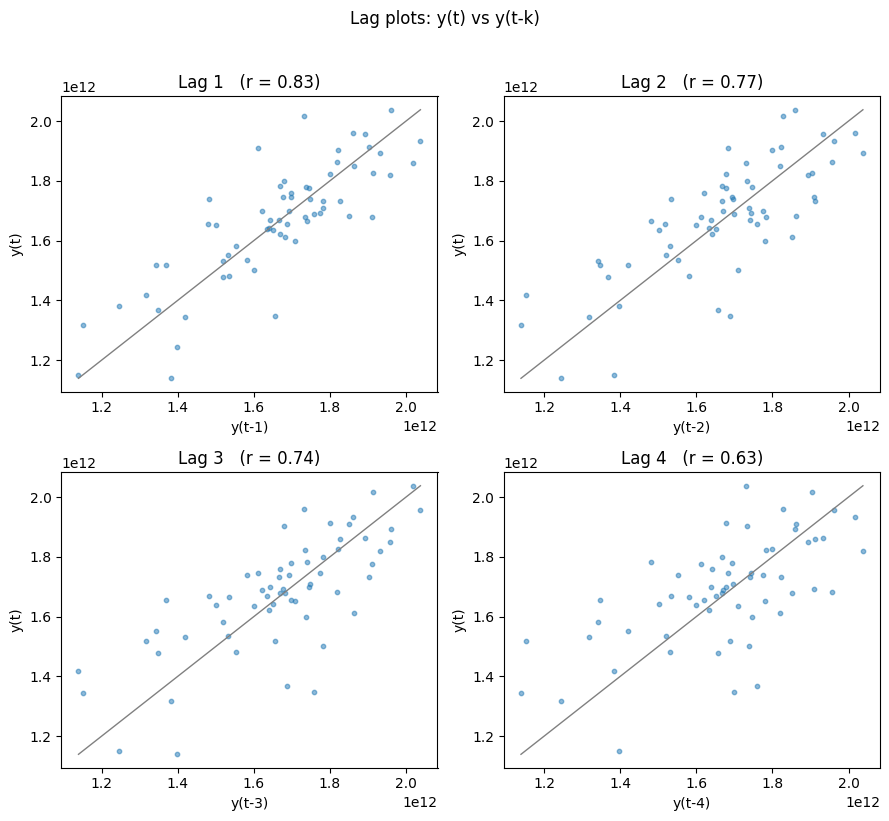


=== Lag correlation table (Pearson r) ===
     pearson_r
lag           
1        0.826
2        0.769
3        0.739
4        0.634
5        0.589
6        0.618
7        0.463
8        0.419
9        0.389
10       0.251
11       0.204
12       0.266
13       0.004
14      -0.109
15      -0.161
16      -0.295
17      -0.377
18      -0.366
19      -0.520
20      -0.549
21      -0.548
22      -0.650
23      -0.625
24      -0.521


In [88]:
lags_to_plot = [1, 2, 3, 4]     
max_lag_tbl  = 24              

def lag_scatter(ax, series, lag):
    df = pd.DataFrame({
        "current": series,
        f"lag{lag}": series.shift(lag)
    }).dropna()
    r = df.corr().iloc[0,1]
    ax.scatter(df[f"lag{lag}"], df["current"], s=10, alpha=0.5)
    lo = np.nanmin(df.values); hi = np.nanmax(df.values)
    ax.plot([lo, hi], [lo, hi], lw=1, color="gray")
    ax.set_title(f"Lag {lag}   (r = {r:.2f})")
    ax.set_xlabel(f"y(t-{lag})")
    ax.set_ylabel("y(t)")
    return r

n = len(lags_to_plot)
rows = 1 if n <= 3 else 2
cols = n if n <= 3 else (n+1)//2
fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 4*rows))
axes = np.array(axes).reshape(-1)  # flat

for ax, L in zip(axes, lags_to_plot):
    lag_scatter(ax, y, L)

for ax in axes[len(lags_to_plot):]:
    ax.axis("off")

fig.suptitle("Lag plots: y(t) vs y(t-k)", y=1.02, fontsize=12)
plt.tight_layout(); plt.show()

corrs = []
for k in range(1, max_lag_tbl+1):
    r = pd.concat([y, y.shift(k)], axis=1).dropna().corr().iloc[0,1]
    corrs.append((k, r))
lag_table = pd.DataFrame(corrs, columns=["lag", "pearson_r"]).set_index("lag")
print("\n=== Lag correlation table (Pearson r) ===")
print(lag_table.to_string(float_format=lambda v: f"{v:.3f}"))


In [90]:
from itertools import product

# data 
value_col = "total_value"  # or "total_kg"
y = (monthly[["ref_date", value_col]]
     .dropna().sort_values("ref_date")
     .set_index("ref_date")[value_col]
     .asfreq("MS"))

# helpers 
def make_dp(idx, fourier_order=2):

    add = [CalendarFourier("A", order=fourier_order)] if fourier_order > 0 else []
    return DeterministicProcess(index=idx, constant=True, order=1, seasonal=True,
                                additional_terms=add, drop=True)

def metrics(y_true, y_pred):
    yt, yp = pd.Series(y_true).align(pd.Series(y_pred), join="inner")
    yt, yp = yt.dropna(), yp.dropna()
    mae = mean_absolute_error(yt, yp)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mape = (np.abs((yt - yp) / yt.replace(0, np.nan))).dropna().mean() * 100
    return mae, rmse, mape

def snaive12(series):
    def predict_next(t_idx):
        if t_idx >= 12:
            return float(series.iloc[t_idx-12])
        else:
            return float(series.iloc[t_idx-1])
    return predict_next

def backtest_once(y, *, use_ridge=True, alpha=1.0, fourier_order=2,
                  lags=(1,12), use_resid_month_dummies=True, min_train=24,
                  res_model=None):
    """
    Expanding one-step-ahead backtest for:
      - Regression (trend+seasonality)
      - Hybrid = Regression + ML(residuals)  [if res_model is not None]
      - SNaive12 baseline
    Returns MAE, RMSE, MAPE for each.
    """
    snaive_next = snaive12(y)

    reg_preds, hyb_preds, sna_preds, actuals = [], [], [], []
    for t in range(min_train, len(y)):
        y_tr   = y.iloc[:t]
        idx_tr = y_tr.index
        idx_1  = y.index[t:t+1]  

        dp_tr = make_dp(idx_tr, fourier_order=fourier_order)
        X_tr  = dp_tr.in_sample()
        X_1   = dp_tr.out_of_sample(steps=1)

        M = Ridge(alpha=alpha) if use_ridge else LinearRegression()
        M.fit(X_tr, y_tr)
        reg_next = float(M.predict(X_1))

        sna_next = snaive_next(t)

        y_fit_tr = pd.Series(M.predict(X_tr), index=idx_tr)
        resid_tr = (y_tr - y_fit_tr)

        if res_model is not None:
            Xres_tr = pd.DataFrame(index=resid_tr.index)
            for k in lags:
                Xres_tr[f"res_lag{k}"] = resid_tr.shift(k)
            if use_resid_month_dummies:
                Xres_tr = pd.concat([Xres_tr,
                                     pd.get_dummies(Xres_tr.index.month, prefix="m", drop_first=True)],
                                    axis=1)
            Xres_tr = Xres_tr.dropna()
            yres_tr = resid_tr.loc[Xres_tr.index]
            if len(Xres_tr) >= max(12, max(lags, default=1)):
                res_model.fit(Xres_tr, yres_tr)
                row = {}
                for k in lags:
                    row[f"res_lag{k}"] = float(resid_tr.iloc[-k]) if len(resid_tr) >= k else 0.0
                m = int(idx_1[0].month)
                if use_resid_month_dummies:
                    for mo in range(2,13):
                        row[f"m_{mo}"] = 1 if m==mo else 0
                Xres_1 = pd.DataFrame([row], index=idx_1)
                res_next = float(res_model.predict(Xres_1))
            else:
                res_next = 0.0
            hyb_next = reg_next + res_next
        else:
            hyb_next = None

        reg_preds.append(reg_next)
        sna_preds.append(sna_next)
        if hyb_next is not None:
            hyb_preds.append(hyb_next)
        actuals.append(float(y.iloc[t]))

    idx_bt = y.index[min_train:]
    reg_bt = pd.Series(reg_preds, index=idx_bt, name="Reg")
    sna_bt = pd.Series(sna_preds, index=idx_bt, name="SNaive12")
    act_bt = pd.Series(actuals, index=idx_bt, name="Actual")
    out = {
        "Reg": metrics(act_bt, reg_bt),
        "SNaive12": metrics(act_bt, sna_bt),
    }
    if res_model is not None:
        hyb_bt = pd.Series(hyb_preds, index=idx_bt, name="Hybrid")
        out["Hybrid"] = metrics(act_bt, hyb_bt)
    return out

use_ridge_grid = [True]           
alpha_grid     = [0.0, 1.0, 2.0] 
fourier_grid   = [0, 1, 2] 
lags_grid      = [(1,), (1,12), (1,2,12)]
dummies_grid   = [True, False]
min_train_grid = [24, 36]

base_res_model = RandomForestRegressor(n_estimators=300, random_state=0)

rows = []
for use_ridge, alpha, f_order, lags, use_dum, mtrain in product(
        use_ridge_grid, alpha_grid, fourier_grid, lags_grid, dummies_grid, min_train_grid):
    if mtrain < max(12, max(lags)):
        continue
    res = backtest_once(
        y,
        use_ridge=use_ridge, alpha=alpha, fourier_order=f_order,
        lags=lags, use_resid_month_dummies=use_dum, min_train=mtrain,
        res_model=base_res_model
    )
    reg_mae, reg_rmse, reg_mape = res["Reg"]
    sna_mae, sna_rmse, sna_mape = res["SNaive12"]
    hyb_mae = hyb_rmse = hyb_mape = np.nan
    if "Hybrid" in res:
        hyb_mae, hyb_rmse, hyb_mape = res["Hybrid"]

    rows.append({
        "use_ridge": use_ridge, "alpha": alpha, "fourier_order": f_order,
        "lags": lags, "resid_dummies": use_dum, "min_train": mtrain,
        "RMSE_Reg": reg_rmse, "MAE_Reg": reg_mae, "MAPE_Reg": reg_mape,
        "RMSE_Hybrid": hyb_rmse, "MAE_Hybrid": hyb_mae, "MAPE_Hybrid": hyb_mape,
        "RMSE_SNaive12": sna_rmse, "MAE_SNaive12": sna_mae, "MAPE_SNaive12": sna_mape
    })

leader = pd.DataFrame(rows)
leader["RMSE_BestModel"] = leader[["RMSE_Hybrid","RMSE_Reg"]].min(axis=1)
leader = leader.sort_values(["RMSE_BestModel","RMSE_SNaive12"]).reset_index(drop=True)
display(leader.head(15))

best = leader.iloc[0].to_dict()
print("\nBest config (by RMSE_BestModel):")
for k in ["use_ridge","alpha","fourier_order","lags","resid_dummies","min_train",
          "RMSE_BestModel","RMSE_Reg","RMSE_Hybrid","RMSE_SNaive12"]:
    print(f"{k}: {best[k]}")

C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2847005580.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reg_next = float(M.predict(X_1))
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2847005580.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reg_next = float(M.predict(X_1))
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\2847005580.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reg_next = float(M.

use_ridge  alpha  fourier_order        lags  resid_dummies  min_train  \
0        True    2.0              1        (1,)          False         36   
1        True    1.0              1        (1,)          False         36   
2        True    2.0              2        (1,)          False         36   
3        True    1.0              1        (1,)          False         24   
4        True    2.0              1        (1,)          False         24   
5        True    1.0              2     (1, 12)          False         36   
6        True    1.0              0     (1, 12)          False         36   
7        True    1.0              2  (1, 2, 12)          False         36   
8        True    1.0              0     (1, 12)          False         24   
9        True    1.0              2        (1,)          False         36   
10       True    1.0              0  (1, 2, 12)          False         24   
11       True    1.0              1     (1, 12)          False         36   
12       True    1.0              0  (1, 2, 12)          False         36   
13       True    1.0              1  (1, 2, 12)          False         36   
14       True    2.0              2        (1,)          False         24   

        RMSE_Reg       MAE_Reg   MAPE_Reg   RMSE_Hybrid    MAE_Hybrid  \
0   2.757526e+11  2.650052e+11  16.291364  1.161254e+11  9.851488e+10   
1   2.782891e+11  2.679511e+11  16.447206  1.175284e+11  1.003307e+11   
2   2.765742e+11  2.668800e+11  16.391478  1.182598e+11  9.877138e+10   
3   2.504817e+11  2.293501e+11  13.773181  1.238645e+11  1.040352e+11   
4   2.479083e+11  2.274285e+11  13.670827  1.251839e+11  1.065811e+11   
5   2.790291e+11  2.693422e+11  16.522328  1.254439e+11  1.073691e+11   
6   2.786419e+11  2.677143e+11  16.452404  1.257398e+11  1.025454e+11   
7   2.790291e+11  2.693422e+11  16.522328  1.258009e+11  1.072632e+11   
8   2.498274e+11  2.274374e+11  13.686350  1.264531e+11  1.055021e+11   
9   2.790291e+11  2.693422e+11  16.522328  1.265087e+11  1.054266e+11   
10  2.498274e+11  2.274374e+11  13.686350  1.265519e+11  1.048844e+11   
11  2.782891e+11  2.679511e+11  16.447206  1.280228e+11  1.080493e+11   
12  2.786419e+11  2.677143e+11  16.452404  1.281569e+11  1.036789e+11   
13  2.782891e+11  2.679511e+11  16.447206  1.281784e+11  1.073820e+11   
14  2.489481e+11  2.290536e+11  13.758606  1.291583e+11  1.086003e+11   

    MAPE_Hybrid  RMSE_SNaive12  MAE_SNaive12  MAPE_SNaive12  RMSE_BestModel  
0      6.024950   1.475104e+11  1.283674e+11       7.861223    1.161254e+11  
1      6.161351   1.475104e+11  1.283674e+11       7.861223    1.175284e+11  
2      6.060544   1.475104e+11  1.283674e+11       7.861223    1.182598e+11  
3      6.137841   1.682135e+11  1.453650e+11       8.423396    1.238645e+11  
4      6.233736   1.682135e+11  1.453650e+11       8.423396    1.251839e+11  
5      6.596540   1.475104e+11  1.283674e+11       7.861223    1.254439e+11  
6      6.302755   1.475104e+11  1.283674e+11       7.861223    1.257398e+11  
7      6.596786   1.475104e+11  1.283674e+11       7.861223    1.258009e+11  
8      6.226426   1.682135e+11  1.453650e+11       8.423396    1.264531e+11  
9      6.515704   1.475104e+11  1.283674e+11       7.861223    1.265087e+11  
10     6.206555   1.682135e+11  1.453650e+11       8.423396    1.265519e+11  
11     6.635254   1.475104e+11  1.283674e+11       7.861223    1.280228e+11  
12     6.381365   1.475104e+11  1.283674e+11       7.861223    1.281569e+11  
13     6.605721   1.475104e+11  1.283674e+11       7.861223    1.281784e+11  
14     6.356981   1.682135e+11  1.453650e+11       8.423396    1.291583e+11


Best config (by RMSE_BestModel):
use_ridge: True
alpha: 2.0
fourier_order: 1
lags: (1,)
resid_dummies: False
min_train: 36
RMSE_BestModel: 116125355122.3873
RMSE_Reg: 275752618227.61035
RMSE_Hybrid: 116125355122.3873
RMSE_SNaive12: 147510430618.497


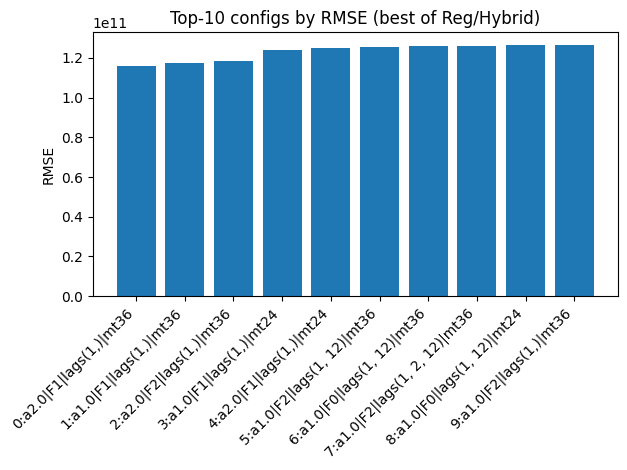

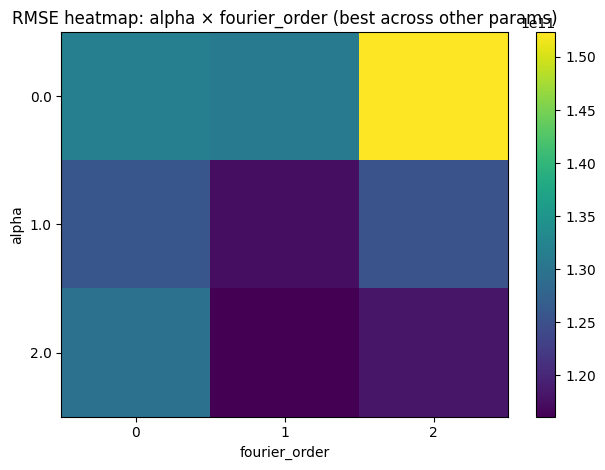

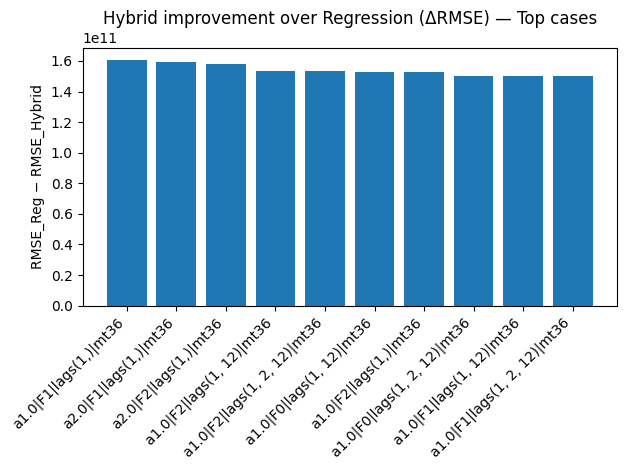

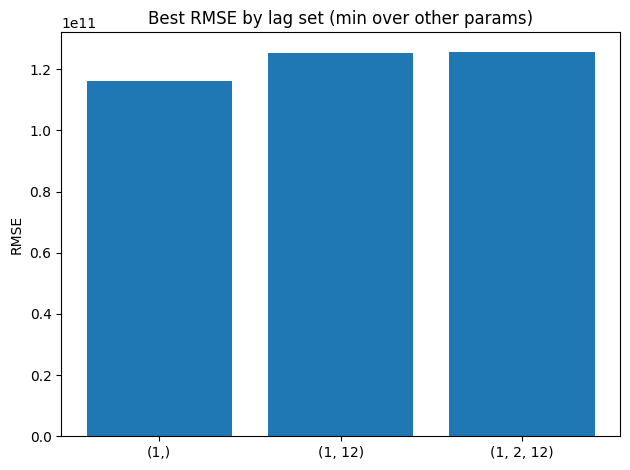

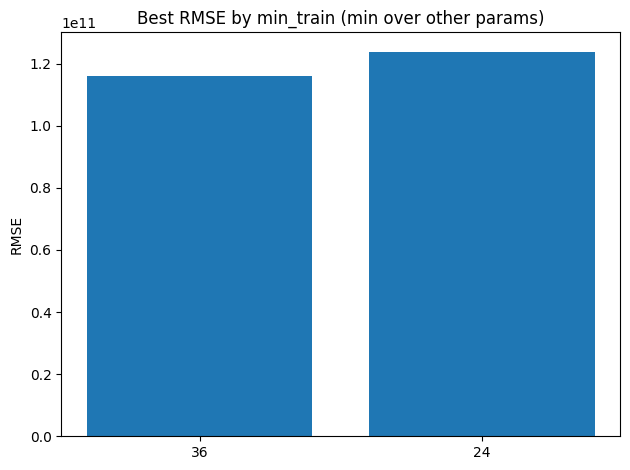

c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\3803033385.py:242: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reg_next = float(M.predict(X_1))
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\3803033385.py:268: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  res_next = float(res_model.predict(Xres_1))
c:\Users\Predator Helios Ne

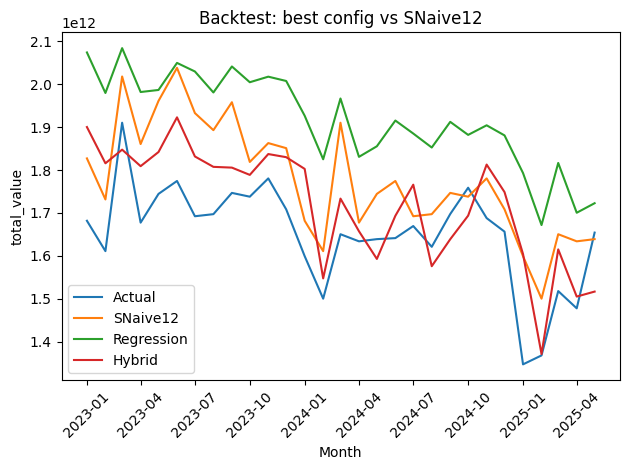

In [91]:
RUN_SMALL_GRID = False

# Optional quick mini-grid (only if needed) 
if RUN_SMALL_GRID or "leader" not in globals():
    from sklearn.linear_model import Ridge, LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

    value_col = "total_value"
    y = (monthly[["ref_date", value_col]]
         .dropna().sort_values("ref_date")
         .set_index("ref_date")[value_col]
         .asfreq("MS"))

    def make_dp(idx, fourier_order=2):
        add = [CalendarFourier("A", order=fourier_order)] if fourier_order>0 else None
        return DeterministicProcess(index=idx, constant=True, order=1, seasonal=True,
                                    additional_terms=add, drop=True)

    def metrics(y_true, y_pred):
        yt, yp = pd.Series(y_true).align(pd.Series(y_pred), join="inner")
        yt, yp = yt.dropna(), yp.dropna()
        mae  = mean_absolute_error(yt, yp)
        rmse = mean_squared_error(yt, yp, squared=False)
        mape = (np.abs((yt-yp) / yt.replace(0, np.nan))).dropna().mean() * 100
        return mae, rmse, mape

    def backtest_once(y, *, use_ridge=True, alpha=1.0, fourier_order=2,
                      lags=(1,12), use_resid_month_dummies=True, min_train=24,
                      res_model=None):
        from sklearn.linear_model import Ridge, LinearRegression
        from sklearn.metrics import mean_absolute_error, mean_squared_error

        def snaive_next_func(series):
            def f(t_idx):
                return float(series.iloc[t_idx-12] if t_idx >= 12 else series.iloc[t_idx-1])
            return f
        snaive_next = snaive_next_func(y)

        reg_preds, hyb_preds, sna_preds, actuals = [], [], [], []
        for t in range(min_train, len(y)):
            y_tr   = y.iloc[:t]
            idx_tr = y_tr.index
            idx_1  = y.index[t:t+1]

            dp_tr = make_dp(idx_tr, fourier_order=fourier_order)
            X_tr  = dp_tr.in_sample()
            X_1   = dp_tr.out_of_sample(steps=1)

            M = Ridge(alpha=alpha) if use_ridge else LinearRegression()
            M.fit(X_tr, y_tr)
            reg_next = float(M.predict(X_1))
            sna_next = snaive_next(t)

            y_fit_tr = pd.Series(M.predict(X_tr), index=idx_tr)
            resid_tr = (y_tr - y_fit_tr)

            if res_model is not None:
                Xres_tr = pd.DataFrame(index=resid_tr.index)
                for k in lags:
                    Xres_tr[f"res_lag{k}"] = resid_tr.shift(k)
                if use_resid_month_dummies:
                    Xres_tr = pd.concat([Xres_tr,
                                         pd.get_dummies(Xres_tr.index.month, prefix="m", drop_first=True)],
                                        axis=1)
                Xres_tr = Xres_tr.dropna()
                yres_tr = resid_tr.loc[Xres_tr.index]
                if len(Xres_tr) >= max(12, max(lags, default=1)):
                    res_model.fit(Xres_tr, yres_tr)
                    row = {}
                    for k in lags:
                        row[f"res_lag{k}"] = float(resid_tr.iloc[-k]) if len(resid_tr) >= k else 0.0
                    m = int(idx_1[0].month)
                    if use_resid_month_dummies:
                        for mo in range(2,13):
                            row[f"m_{mo}"] = 1 if m==mo else 0
                    Xres_1 = pd.DataFrame([row], index=idx_1)
                    res_next = float(res_model.predict(Xres_1))
                else:
                    res_next = 0.0
                hyb_next = reg_next + res_next
            else:
                hyb_next = None

            reg_preds.append(reg_next)
            sna_preds.append(sna_next)
            if hyb_next is not None:
                hyb_preds.append(hyb_next)
            actuals.append(float(y.iloc[t]))

        idx_bt = y.index[min_train:]
        reg_bt = pd.Series(reg_preds, index=idx_bt, name="Reg")
        sna_bt = pd.Series(sna_preds, index=idx_bt, name="SNaive12")
        act_bt = pd.Series(actuals, index=idx_bt, name="Actual")

        out = {
            "Reg": metrics(act_bt, reg_bt),
            "SNaive12": metrics(act_bt, sna_bt),
        }
        if res_model is not None:
            hyb_bt = pd.Series(hyb_preds, index=idx_bt, name="Hybrid")
            out["Hybrid"] = metrics(act_bt, hyb_bt)
        return out

    from sklearn.ensemble import RandomForestRegressor
    base_res_model = RandomForestRegressor(n_estimators=200, random_state=0)

    use_ridge_grid = [True]
    alpha_grid     = [0.0, 1.0]
    fourier_grid   = [0, 2]
    lags_grid      = [(1,), (1,12)]
    dummies_grid   = [True]
    min_train_grid = [24, 36, 50]

    rows = []
    for use_ridge, alpha, f_order, lags, use_dum, mtrain in product(
            use_ridge_grid, alpha_grid, fourier_grid, lags_grid, dummies_grid, min_train_grid):
        if mtrain < max(12, max(lags)):
            continue
        res = backtest_once(
            y,
            use_ridge=use_ridge, alpha=alpha, fourier_order=f_order,
            lags=lags, use_resid_month_dummies=use_dum, min_train=mtrain,
            res_model=base_res_model
        )
        reg_mae, reg_rmse, reg_mape = res["Reg"]
        sna_mae, sna_rmse, sna_mape = res["SNaive12"]
        hyb_mae = hyb_rmse = hyb_mape = np.nan
        if "Hybrid" in res:
            hyb_mae, hyb_rmse, hyb_mape = res["Hybrid"]

        rows.append({
            "use_ridge": use_ridge, "alpha": alpha, "fourier_order": f_order,
            "lags": lags, "resid_dummies": use_dum, "min_train": mtrain,
            "RMSE_Reg": reg_rmse, "MAE_Reg": reg_mae, "MAPE_Reg": reg_mape,
            "RMSE_Hybrid": hyb_rmse, "MAE_Hybrid": hyb_mae, "MAPE_Hybrid": hyb_mape,
            "RMSE_SNaive12": sna_rmse, "MAE_SNaive12": sna_mae, "MAPE_SNaive12": sna_mape
        })

    leader = pd.DataFrame(rows)
    leader["RMSE_BestModel"] = leader[["RMSE_Hybrid","RMSE_Reg"]].min(axis=1)
    leader = leader.sort_values(["RMSE_BestModel","RMSE_SNaive12"]).reset_index(drop=True)

# 1) Top-10 leaderboard (bar) 
top = leader.nsmallest(10, "RMSE_BestModel")
plt.figure()
plt.bar(range(len(top)), top["RMSE_BestModel"].values)
plt.xticks(range(len(top)), [f"{i}:a{a}|F{f}|lags{l}|mt{mt}"
                             for i,(a,f,l,mt) in enumerate(zip(top["alpha"], top["fourier_order"],
                                                               top["lags"], top["min_train"]))],
           rotation=45, ha='right')
plt.title("Top-10 configs by RMSE (best of Reg/Hybrid)")
plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

# 2) Heatmap alpha × fourier_order (fix lags/min_train/dummies if possible) 
subset = leader.copy()
pivot = (subset.groupby(["alpha","fourier_order"])["RMSE_BestModel"]
         .min().reset_index().pivot(index="alpha", columns="fourier_order", values="RMSE_BestModel"))
plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.xticks(range(pivot.shape[1]), pivot.columns)
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.title("RMSE heatmap: alpha × fourier_order (best across other params)")
plt.xlabel("fourier_order"); plt.ylabel("alpha"); plt.colorbar(); plt.tight_layout(); plt.show()

# 3) Hybrid gain over Regression (positive = hybrid helped) 
hyb = leader.dropna(subset=["RMSE_Hybrid"]).copy()
if not hyb.empty:
    hyb["Hybrid_gain"] = hyb["RMSE_Reg"] - hyb["RMSE_Hybrid"]
    hyb_top = hyb.sort_values("Hybrid_gain", ascending=False).head(10)
    plt.figure()
    plt.bar(range(len(hyb_top)), hyb_top["Hybrid_gain"].values)
    plt.xticks(range(len(hyb_top)),
               [f"a{a}|F{f}|lags{l}|mt{mt}" for a,f,l,mt in
                zip(hyb_top["alpha"], hyb_top["fourier_order"], hyb_top["lags"], hyb_top["min_train"])],
               rotation=45, ha='right')
    plt.title("Hybrid improvement over Regression (ΔRMSE) — Top cases")
    plt.ylabel("RMSE_Reg − RMSE_Hybrid"); plt.tight_layout(); plt.show()

# 4) Lags ablation: which lag set works best 
lags_best = (leader.groupby("lags")["RMSE_BestModel"].min().sort_values())
plt.figure()
plt.bar(range(len(lags_best)), lags_best.values)
plt.xticks(range(len(lags_best)), [str(k) for k in lags_best.index], rotation=0)
plt.title("Best RMSE by lag set (min over other params)")
plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

# 5) min_train sensitivity 
mt_best = (leader.groupby("min_train")["RMSE_BestModel"].min().sort_values())
plt.figure()
plt.bar(range(len(mt_best)), mt_best.values)
plt.xticks(range(len(mt_best)), mt_best.index.astype(str))
plt.title("Best RMSE by min_train (min over other params)")
plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

# 6) Backtest curves for the *best* config 
best = leader.iloc[0].to_dict()

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

value_col = "total_value"
y = (monthly[["ref_date", value_col]]
     .dropna().sort_values("ref_date")
     .set_index("ref_date")[value_col]
     .asfreq("MS"))

def make_dp(idx, fourier_order=2):
    add = [CalendarFourier("A", order=fourier_order)] if fourier_order>0 else None
    return DeterministicProcess(index=idx, constant=True, order=1, seasonal=True,
                                additional_terms=add, drop=True)

def backtest_series(y, cfg, res_model=None):
    reg_preds, hyb_preds, sna_preds, actuals = [], [], [], []
    min_train = int(cfg["min_train"])
    use_ridge = bool(cfg["use_ridge"])
    alpha     = float(cfg["alpha"])
    f_order   = int(cfg["fourier_order"])
    lags      = tuple(cfg["lags"]) if not isinstance(cfg["lags"], tuple) else cfg["lags"]
    use_dum   = bool(cfg["resid_dummies"])

    def snaive_next_func(series):
        def f(t_idx):
            return float(series.iloc[t_idx-12] if t_idx >= 12 else series.iloc[t_idx-1])
        return f
    snaive_next = snaive_next_func(y)

    for t in range(min_train, len(y)):
        y_tr   = y.iloc[:t]
        idx_tr = y_tr.index
        idx_1  = y.index[t:t+1]

        dp_tr = make_dp(idx_tr, fourier_order=f_order)
        X_tr  = dp_tr.in_sample()
        X_1   = dp_tr.out_of_sample(steps=1)

        M = Ridge(alpha=alpha) if use_ridge else LinearRegression()
        M.fit(X_tr, y_tr)
        reg_next = float(M.predict(X_1))
        sna_next = snaive_next(t)

        # residuals on training window
        y_fit_tr = pd.Series(M.predict(X_tr), index=idx_tr)
        resid_tr = (y_tr - y_fit_tr)

        if res_model is not None:
            Xres_tr = pd.DataFrame(index=resid_tr.index)
            for k in lags:
                Xres_tr[f"res_lag{k}"] = resid_tr.shift(k)
            if use_dum:
                Xres_tr = pd.concat([Xres_tr,
                                     pd.get_dummies(Xres_tr.index.month, prefix="m", drop_first=True)], axis=1)
            Xres_tr = Xres_tr.dropna()
            yres_tr = resid_tr.loc[Xres_tr.index]
            if len(Xres_tr) >= max(12, max(lags, default=1)):
                res_model.fit(Xres_tr, yres_tr)
                row = {}
                for k in lags:
                    row[f"res_lag{k}"] = float(resid_tr.iloc[-k]) if len(resid_tr) >= k else 0.0
                m = int(idx_1[0].month)
                if use_dum:
                    for mo in range(2,13):
                        row[f"m_{mo}"] = 1 if m==mo else 0
                Xres_1 = pd.DataFrame([row], index=idx_1)
                res_next = float(res_model.predict(Xres_1))
            else:
                res_next = 0.0
            hyb_next = reg_next + res_next
        else:
            hyb_next = None

        reg_preds.append(reg_next)
        sna_preds.append(sna_next)
        if hyb_next is not None:
            hyb_preds.append(hyb_next)
        actuals.append(float(y.iloc[t]))

    idx_bt = y.index[min_train:]
    series = {
        "Actual": pd.Series(actuals, index=idx_bt),
        "Reg": pd.Series(reg_preds, index=idx_bt),
        "SNaive12": pd.Series(sna_preds, index=idx_bt),
    }
    if res_model is not None:
        series["Hybrid"] = pd.Series(hyb_preds, index=idx_bt)
    return series

res_model = RandomForestRegressor(n_estimators=300, random_state=0) if not np.isnan(best.get("RMSE_Hybrid", np.nan)) else None
bt = backtest_series(y, best, res_model=res_model)

plt.figure()
plt.plot(bt["Actual"].index, bt["Actual"].values, label="Actual")
plt.plot(bt["SNaive12"].index, bt["SNaive12"].values, label="SNaive12")
plt.plot(bt["Reg"].index, bt["Reg"].values, label="Regression")
if "Hybrid" in bt:
    plt.plot(bt["Hybrid"].index, bt["Hybrid"].values, label="Hybrid")
plt.title("Backtest: best config vs SNaive12")
plt.xlabel("Month"); plt.ylabel(value_col)
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()
# =========================================================================================


c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\591006190.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reg_pred = float(M.predict(X_1))
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\591006190.py:123: DeprecationW

MAE          RMSE      MAPE%
Hybrid = Reg + ML(resid)  9.983291e+10  1.183779e+11   6.154306
SNaive12                  1.283674e+11  1.475104e+11   7.861223
Regression                2.679511e+11  2.782891e+11  16.447206
LTwS (CMAT)               2.750016e+11  2.884712e+11  16.852430

c:\Users\Predator Helios Neo\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\591006190.py:188: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_hat = float(res_model.predict(X1)) if not Xres_full.empty else 0.0
C:\Users\Predator Helios Neo\AppData\Local\Temp\ipykernel_32548\591006190.py:188: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  r_hat = float(res_model.predict(X1)) 

Reg_forecast  Hybrid_forecast      SNaive12  LTwS_forecast
2025-06-01  1.790883e+12     1.713168e+12  1.641475e+12   1.813557e+12
2025-07-01  1.779271e+12     1.736346e+12  1.669564e+12   1.756397e+12
2025-08-01  1.747334e+12     1.676401e+12  1.621239e+12   1.715698e+12
2025-09-01  1.829197e+12     1.777569e+12  1.697593e+12   1.790182e+12
2025-10-01  1.817844e+12     1.776025e+12  1.758772e+12   1.774401e+12
2025-11-01  1.832232e+12     1.750171e+12  1.688035e+12   1.793942e+12

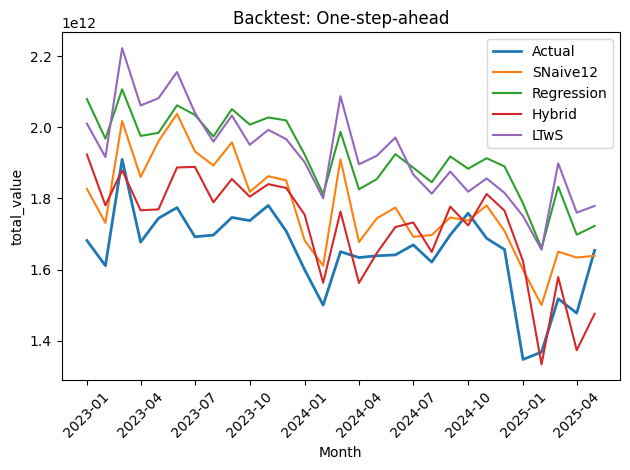

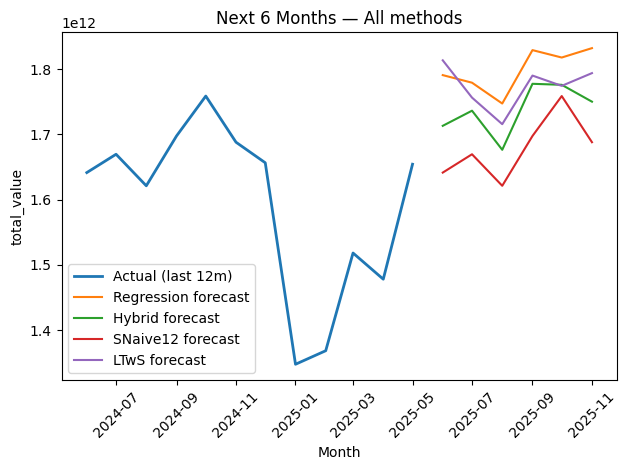

In [94]:
# ---- settings ----
value_col      = "total_value"   # or "total_kg"
H              = 6               # forecast horizon
use_ridge      = True            # ridge or OLS
fourier_order  = 1            
min_train      = 36
residual_lags  = (1,)      # lags for the Hybrid residual learner
res_model      = RandomForestRegressor(n_estimators=300, random_state=0)
cma_window     = 12              # MA window for LTwS (CMAT)

#  target series (monthly) 
y = (monthly[["ref_date", value_col]]
     .dropna().sort_values("ref_date")
     .set_index("ref_date")[value_col]
     .asfreq("MS"))

#  helper: build regression design (DeterministicProcess) 
def make_dp(idx):
    add = [CalendarFourier("A", order=fourier_order)] if fourier_order > 0 else None
    return DeterministicProcess(index=idx, constant=True, order=1, seasonal=True,
                                additional_terms=add, drop=True)

#  helper: make residual features (lags + calendar) 
def make_residual_features(index, residual_series):
    df = pd.DataFrame(index=index)
    for k in residual_lags:
        df[f"res_lag{k}"] = residual_series.shift(k)
    mo = index.month
    X_month = pd.get_dummies(mo, prefix="m", drop_first=True)
    feats = pd.concat([df, X_month.set_index(index)], axis=1)
    return feats

#  LTwS helpers (CMAT method)
def cma_even_ma(series, window=12):
    """Proper centered moving average for an even window:
       CMA = average of two adjacent MA(window)."""
    ma = series.rolling(window, min_periods=window).mean()
    cma = (ma.shift(1) + ma) / 2.0  
    return cma

def seasonal_indices_from_cma(series, cma):
    """Compute seasonal indices (multiplicative), normalized to mean 1."""
    ratio = series / cma
    si = ratio.groupby(ratio.index.month).mean()
    si = si / si.mean()  
    return si

def ltws_one_step_forecast(y_train, window=12):
    """Build CMAT pieces on y_train only, then predict the NEXT month."""
    if len(y_train) < 2*window: 
        return np.nan
    cma = cma_even_ma(y_train, window=window)
    valid = cma.dropna()
    if valid.empty:
        return np.nan

    t = np.arange(1, len(valid)+1)
    b, a = np.polyfit(t, valid.values, 1)  
    si = seasonal_indices_from_cma(y_train, cma)
    t_next = len(valid) + 1
    month_next = (y_train.index[-1] + pd.offsets.MonthBegin(1)).month
    trend_next = a + b * t_next
    ltws_next  = trend_next * float(si.get(month_next, 1.0))
    return ltws_next

def ltws_h_forecast(y_all, steps=6, window=12):
    """Forecast H months ahead using fixed SI & trend estimated on all history."""
    if len(y_all) < 2*window:
        return pd.Series([np.nan]*steps,
                         index=pd.date_range(y_all.index[-1]+pd.offsets.MonthBegin(1),
                                             periods=steps, freq="MS"))
    cma = cma_even_ma(y_all, window=window)
    valid = cma.dropna()
    t = np.arange(1, len(valid)+1)
    b, a = np.polyfit(t, valid.values, 1)
    si = seasonal_indices_from_cma(y_all, cma)
    idx_future = pd.date_range(y_all.index[-1]+pd.offsets.MonthBegin(1), periods=steps, freq="MS")
    t_future = np.arange(len(valid)+1, len(valid)+1+steps)
    trend_fc = a + b*t_future
    si_vec = np.array([float(si.get(m, 1.0)) for m in idx_future.month])
    ltws = trend_fc * si_vec
    return pd.Series(ltws, index=idx_future, name="LTwS_forecast")

#1) Fit regression on all history; get in-sample residuals (for info)
dp_all = make_dp(y.index)
X_all  = dp_all.in_sample()
Reg    = Ridge(alpha=1.0) if use_ridge else LinearRegression()
Reg.fit(X_all, y)
y_fit  = pd.Series(Reg.predict(X_all), index=y.index, name="Reg_fit")
resid  = (y - y_fit).rename("resid")

# 2) Expanding backtest: SNaive12 vs Regression vs HYBRID vs LTwS 
reg_bt, sna_bt, hyb_bt, ltws_bt, act_bt = [], [], [], [], []
for t in range(min_train, len(y)):
    y_tr   = y.iloc[:t]
    idx_tr = y_tr.index
    idx_1  = y.index[t:t+1]

    dp_tr  = make_dp(idx_tr)
    X_tr   = dp_tr.in_sample()
    X_1    = dp_tr.out_of_sample(steps=1)
    M      = Ridge(alpha=1.0) if use_ridge else LinearRegression()
    M.fit(X_tr, y_tr)
    reg_pred = float(M.predict(X_1))

    sna_pred = float(y.iloc[t-12] if t >= 12 else y_tr.iloc[-1])

    y_fit_tr = pd.Series(M.predict(X_tr), index=idx_tr)
    resid_tr = (y_tr - y_fit_tr)

    # Residual features (training window)
    Xres_tr = make_residual_features(idx_tr, resid_tr).dropna()
    yres_tr = resid_tr.loc[Xres_tr.index]
    if len(Xres_tr) >= 12:
        res_model.fit(Xres_tr, yres_tr)
        row = {}
        for k in residual_lags:
            row[f"res_lag{k}"] = float(resid_tr.iloc[-k]) if len(resid_tr) >= k else 0.0
        m = int(idx_1[0].month)
        for k in range(2,13):
            row[f"m_{k}"] = 1 if m==k else 0
        Xres_1 = pd.DataFrame([row], index=idx_1)
        res_pred = float(res_model.predict(Xres_1))
    else:
        res_pred = 0.0
    hyb_pred = reg_pred + res_pred

    ltws_pred = ltws_one_step_forecast(y_tr, window=cma_window)

    reg_bt.append(reg_pred)
    sna_bt.append(sna_pred)
    hyb_bt.append(hyb_pred)
    ltws_bt.append(ltws_pred)
    act_bt.append(float(y.iloc[t]))

idx_bt  = y.index[min_train:]
reg_bt  = pd.Series(reg_bt,  index=idx_bt, name="Reg(1-step)")
sna_bt  = pd.Series(sna_bt,  index=idx_bt, name="SNaive12")
hyb_bt  = pd.Series(hyb_bt,  index=idx_bt, name="Hybrid(1-step)")
ltws_bt = pd.Series(ltws_bt, index=idx_bt, name="LTwS(1-step)")
act_bt  = pd.Series(act_bt,  index=idx_bt, name="Actual")

# 3) Backtest metrics
def metrics(y_true, y_pred):
    yt, yp = pd.Series(y_true).align(pd.Series(y_pred), join="inner")
    yt, yp = yt.dropna(), yp.dropna()
    mae = mean_absolute_error(yt, yp)
    try:
        rmse = mean_squared_error(yt, yp, squared=False)
    except TypeError:
        rmse = np.sqrt(mean_squared_error(yt, yp))
    mape = (np.abs((yt - yp) / yt.replace(0, np.nan))).dropna().mean() * 100
    return pd.Series({"MAE": mae, "RMSE": rmse, "MAPE%": mape})

leaderboard = pd.concat([
    metrics(act_bt, sna_bt).rename("SNaive12"),
    metrics(act_bt, reg_bt).rename("Regression"),
    metrics(act_bt, hyb_bt).rename("Hybrid = Reg + ML(resid)"),
    metrics(act_bt, ltws_bt).rename("LTwS (CMAT)"),
], axis=1).T.sort_values("RMSE")
display(leaderboard)

# 4) 6-month forecast for all metho
dp_full  = make_dp(y.index)
X_full   = dp_full.in_sample()
Reg_full = Ridge(alpha=1.0) if use_ridge else LinearRegression()
Reg_full.fit(X_full, y)
y_fit_full = pd.Series(Reg_full.predict(X_full), index=y.index)
resid_full = (y - y_fit_full)

Xres_full = make_residual_features(y.index, resid_full).dropna()
if not Xres_full.empty:
    res_model.fit(Xres_full, resid_full.loc[Xres_full.index])

future_idx = pd.date_range(y.index[-1] + pd.offsets.MonthBegin(1), periods=H, freq="MS")
dp_future  = dp_full.out_of_sample(steps=H)
reg_fc     = pd.Series(Reg_full.predict(dp_future), index=future_idx, name="Reg_forecast")


lag_vals = {k: float(resid_full.iloc[-k]) if len(resid_full)>=k else 0.0 for k in residual_lags}
res_fc = []
for d in future_idx:
    row = {f"res_lag{k}": lag_vals[k] for k in residual_lags}
    m = d.month
    for k in range(2,13):
        row[f"m_{k}"] = 1 if m==k else 0
    X1 = pd.DataFrame([row], index=[d])
    r_hat = float(res_model.predict(X1)) if not Xres_full.empty else 0.0
    res_fc.append(r_hat)
    for k in sorted(residual_lags, reverse=True):
        if k == 1:
            lag_vals[1] = r_hat
        else:
            lag_vals[k] = lag_vals.get(k-1, lag_vals[k])

res_fc = pd.Series(res_fc, index=future_idx, name="Residual_forecast")
hyb_fc = (reg_fc + res_fc).rename("Hybrid_forecast")

# Seasonal-Naive(12) forecast
def snaive12(series, steps):
    last12 = series.iloc[-12:]
    reps = int(np.ceil(steps/12))
    return pd.Series(np.tile(last12.values, reps)[:steps], index=future_idx)
sna_fc = snaive12(y, H).rename("SNaive12")

# LTwS forecast on all data
ltws_fc = ltws_h_forecast(y, steps=H, window=cma_window)

#  5) Tables & plots 
fc_table = pd.concat([reg_fc, hyb_fc, sna_fc, ltws_fc], axis=1)
display(fc_table)

plt.figure()
plt.plot(act_bt.index, act_bt.values, label="Actual", linewidth=2)
plt.plot(sna_bt.index, sna_bt.values, label="SNaive12")
plt.plot(reg_bt.index, reg_bt.values, label="Regression")
plt.plot(hyb_bt.index, hyb_bt.values, label="Hybrid")
plt.plot(ltws_bt.index, ltws_bt.values, label="LTwS")
plt.title("Backtest: One-step-ahead"); plt.xlabel("Month"); plt.ylabel(value_col)
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(y.tail(12).index, y.tail(12).values, label="Actual (last 12m)", linewidth=2)
plt.plot(reg_fc.index, reg_fc.values, label="Regression forecast")
plt.plot(hyb_fc.index, hyb_fc.values, label="Hybrid forecast")
plt.plot(sna_fc.index, sna_fc.values, label="SNaive12 forecast")
plt.plot(ltws_fc.index, ltws_fc.values, label="LTwS forecast")
plt.title("Next 6 Months — All methods"); plt.xlabel("Month"); plt.ylabel(value_col)
plt.xticks(rotation=45); plt.legend(); plt.tight_layout(); plt.show()
# ==============================================================================================

In [95]:
def print_onecol(series, name="Value", last_n=None, decimals=0):
    """Print a single-column table (no index/month), nicely formatted."""
    if series is None:
        print(f"[{name}] not found.")
        return
    s = pd.Series(series).dropna()
    if last_n is not None:
        s = s.tail(last_n)
    df = pd.DataFrame({name: s.values})
    fmt = {name: (lambda v: f"{v:,.{decimals}f}")} if decimals > 0 else {name: (lambda v: f"{v:,.0f}")}
    print(df.to_string(index=False, header=True, formatters=fmt))

print_onecol(act_bt,  name="Actual")       
print_onecol(sna_bt,  name="SNaive12")       
print_onecol(reg_bt,  name="Regression")     
print_onecol(hyb_bt,  name="Hybrid")         
print_onecol(ltws_bt, name="LTwS")         
hyb_bt 

           Actual
1,681,851,255,155
1,611,175,716,445
1,910,005,820,277
1,677,503,508,660
1,744,394,603,621
1,774,463,831,193
1,692,371,639,212
1,697,224,906,841
1,746,709,948,282
1,737,887,837,282
1,780,472,206,160
1,708,462,226,753
1,599,464,287,645
1,500,539,031,481
1,650,536,845,231
1,633,989,814,519
1,639,076,780,508
1,641,475,497,256
1,669,564,038,260
1,621,239,047,502
1,697,592,688,172
1,758,772,410,394
1,688,034,715,184
1,656,508,604,791
1,347,666,208,260
1,368,442,215,533
1,518,197,647,834
1,478,058,474,756
1,654,318,827,113
         SNaive12
1,827,000,671,729
1,731,489,939,552
2,017,678,366,059
1,860,437,971,459
1,960,877,565,082
2,037,698,170,434
1,932,447,479,773
1,892,712,664,976
1,957,725,796,622
1,818,717,780,177
1,862,633,908,491
1,850,852,699,957
1,681,851,255,155
1,611,175,716,445
1,910,005,820,277
1,677,503,508,660
1,744,394,603,621
1,774,463,831,193
1,692,371,639,212
1,697,224,906,841
1,746,709,948,282
1,737,887,837,282
1,780,472,206,160
1,708,462,226,753
1,599,464,

ref_date
2023-01-01    1.923488e+12
2023-02-01    1.780749e+12
2023-03-01    1.879403e+12
2023-04-01    1.766789e+12
2023-05-01    1.769520e+12
2023-06-01    1.887174e+12
2023-07-01    1.888738e+12
2023-08-01    1.789288e+12
2023-09-01    1.854748e+12
2023-10-01    1.805191e+12
2023-11-01    1.840294e+12
2023-12-01    1.829574e+12
2024-01-01    1.754345e+12
2024-02-01    1.563121e+12
2024-03-01    1.763423e+12
2024-04-01    1.562702e+12
2024-05-01    1.646909e+12
2024-06-01    1.719631e+12
2024-07-01    1.732634e+12
2024-08-01    1.649926e+12
2024-09-01    1.777076e+12
2024-10-01    1.724362e+12
2024-11-01    1.812635e+12
2024-12-01    1.765735e+12
2025-01-01    1.623798e+12
2025-02-01    1.333946e+12
2025-03-01    1.579238e+12
2025-04-01    1.373566e+12
2025-05-01    1.476063e+12
Freq: MS, Name: Hybrid(1-step), dtype: float64

In [96]:
def print_forecast_column(series, name="Forecast", decimals=0):
    """Print one-column table from a forecast Series/array (no index/month)."""
    s = pd.Series(series).dropna()
    df = pd.DataFrame({name: s.values})
    fmt = {name: (lambda v: f"{v:,.{decimals}f}")} if decimals>0 else {name: (lambda v: f"{v:,.0f}")}
    print(df.to_string(index=False, header=True, formatters=fmt))

print_forecast_column(hyb_fc, "Hybrid forecast")        
print_forecast_column(reg_fc, "Regression forecast")    
print_forecast_column(sna_fc, "SNaive12 forecast")      

print_forecast_column(ltws_fc, "LTwS (CMAT) forecast")


  Hybrid forecast
1,713,168,073,583
1,736,345,526,669
1,676,401,465,215
1,777,568,825,286
1,776,025,186,926
1,750,170,903,328
Regression forecast
  1,790,882,889,248
  1,779,271,460,644
  1,747,334,429,865
  1,829,196,767,501
  1,817,844,231,546
  1,832,232,495,085
SNaive12 forecast
1,641,475,497,256
1,669,564,038,260
1,621,239,047,502
1,697,592,688,172
1,758,772,410,394
1,688,034,715,184
LTwS (CMAT) forecast
   1,813,557,456,101
   1,756,397,141,578
   1,715,697,987,195
   1,790,182,044,971
   1,774,401,488,915
   1,793,942,021,956
